In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!python3 -c "import torch; print(torch.__version__)"

1.13.1


In [3]:
#!pip3 install torch torchvision
import torch
import torch.nn as nn
import numpy as np
from numpy import inf

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(0)

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class BaseGNNLayer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        lim = 1  
        self.w_self = -2 * lim * torch.rand(input_dim, output_dim) + lim
        self.w_neigh = -2 * lim * torch.rand(input_dim, output_dim) + lim

    def forward(self, node_feats, adj_matrix):
        node_feats_self = torch.mm(node_feats, self.w_self) 
        node_feats_neigh = torch.mm(torch.mm(adj_matrix, node_feats), self.w_neigh)

        next_node_feats = node_feats_self + \
                        node_feats_neigh 
        return next_node_feats

In [5]:
threshold=1
def act_fn(x):
    return torch.clamp(x, min=-threshold, max=threshold)

In [6]:
class BaseGNNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=act_fn):
        super().__init__()
        self.layers = nn.ModuleList([BaseGNNLayer(input_dim, hidden_dim)])
        for i in range(num_layers - 2):
            self.layers.append(BaseGNNLayer(hidden_dim, hidden_dim))
        self.layers.append(BaseGNNLayer(hidden_dim, output_dim))
        self.act_fn = act_fn

    def forward(self, x, adj_matrix):
        for layer in self.layers:
            x = self.act_fn(layer(x, adj_matrix))
        return x

In [7]:
class MLPModule(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=torch.tanh):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)])
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.act_fn = act_fn

    def forward(self, x):
        for layer in self.layers:
            x = self.act_fn(layer(x))
        return torch.sigmoid(x)

In [ ]:
csv = []

for d in [64]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                base_gnn = BaseGNNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh)
                # Save Model
                
                #torch.save(base_gnn,f"/Users/.../Desktop/.../th1_base_gnn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                #torch.save(mlp,f"/Users/.../Desktop/.../th1_mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [10, 50, 100, 500, 1000, 2000, 5000, 
                                  10000, 15000, 20000, 50000, 100000,
                                  150000, 200000, 500000]:
                    print(graph_dim)

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = base_gnn(initial_node_feats, adj_matrix).mean(axis=0)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


10
50
100
500
1000
2000
5000
10000
15000
20000
50000


In [18]:
csv

[[64, 0.5, 1, 0, [25, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 1, [23, 31, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 2, [32, 32, 30, 31, 29, 25, 22]],
 [64, 0.5, 1, 3, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 1, 4, [0, 1, 1, 0, 0, 1, 0]],
 [64, 0.5, 1, 5, [32, 32, 32, 31, 32, 32, 32]],
 [64, 0.5, 1, 6, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 1, 7, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 1, 8, [16, 15, 15, 10, 6, 6, 1]],
 [64, 0.5, 1, 9, [18, 1, 1, 0, 0, 0, 0]],
 [64, 0.5, 2, 0, [2, 0, 1, 1, 0, 0, 0]],
 [64, 0.5, 2, 1, [12, 7, 6, 4, 0, 0, 0]],
 [64, 0.5, 2, 2, [27, 30, 31, 32, 31, 29, 26]],
 [64, 0.5, 2, 3, [21, 13, 8, 0, 0, 0, 0]],
 [64, 0.5, 2, 4, [0, 4, 2, 0, 1, 0, 0]],
 [64, 0.5, 2, 5, [32, 31, 31, 32, 32, 32, 32]],
 [64, 0.5, 2, 6, [7, 1, 2, 0, 0, 0, 0]],
 [64, 0.5, 2, 7, [24, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 2, 8, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 2, 9, [28, 13, 19, 22, 20, 14, 4]],
 [64, 0.5, 3, 0, [32, 14, 8, 1, 2, 2, 0]],
 [64, 0.5, 3, 1, [10, 21, 13, 8, 1, 1, 0]],
 [64, 0.5, 3, 2, [32, 32, 32, 

An example output:\
d, r, num_layers, mpnn_idx, (#true 5,10,15) \
[64, 0.5, 1, 0, [4, 19, 17]] \
[64, 0.5, 1, 1, [16, 15, 27]]\
[64, 0.5, 2, 0, [18, 32, 32]]\
[64, 0.5, 2, 1, [0, 0, 0]]\
[64, 0.5, 3, 0, [5, 0, 8]]\
[64, 0.5, 3, 1, [11, 13, 6]]

In [20]:
import matplotlib.pyplot as plt
import pickle
#generate 3 images
csv_numLayer_1 = [item[-1] for item in csv if item[2] == 1]
csv_numLayer_2 = [item[-1] for item in csv if item[2] == 2]
csv_numLayer_3 = [item[-1] for item in csv if item[2] == 3]

In [21]:
# path_1 = f"/Users/.../Desktop/.../sum_num_1.pickle"
# with open(path_1, 'wb') as handle:
#     pickle.dump(csv_numLayer_1,handle)

# path_2 = f"/Users/.../Desktop/.../sum_num_2.pickle"
# with open(path_2, 'wb') as handle:
#     pickle.dump(csv_numLayer_2,handle)

# path_3 = f"/Users/.../Desktop/.../sum_num_3.pickle"
# with open(path_3, 'wb') as handle:
#     pickle.dump(csv_numLayer_3,handle)

In [22]:
x = [10, 50, 100, 500, 1000, 2000, 5000]

In [23]:
plt.rcParams['figure.dpi'] = 600

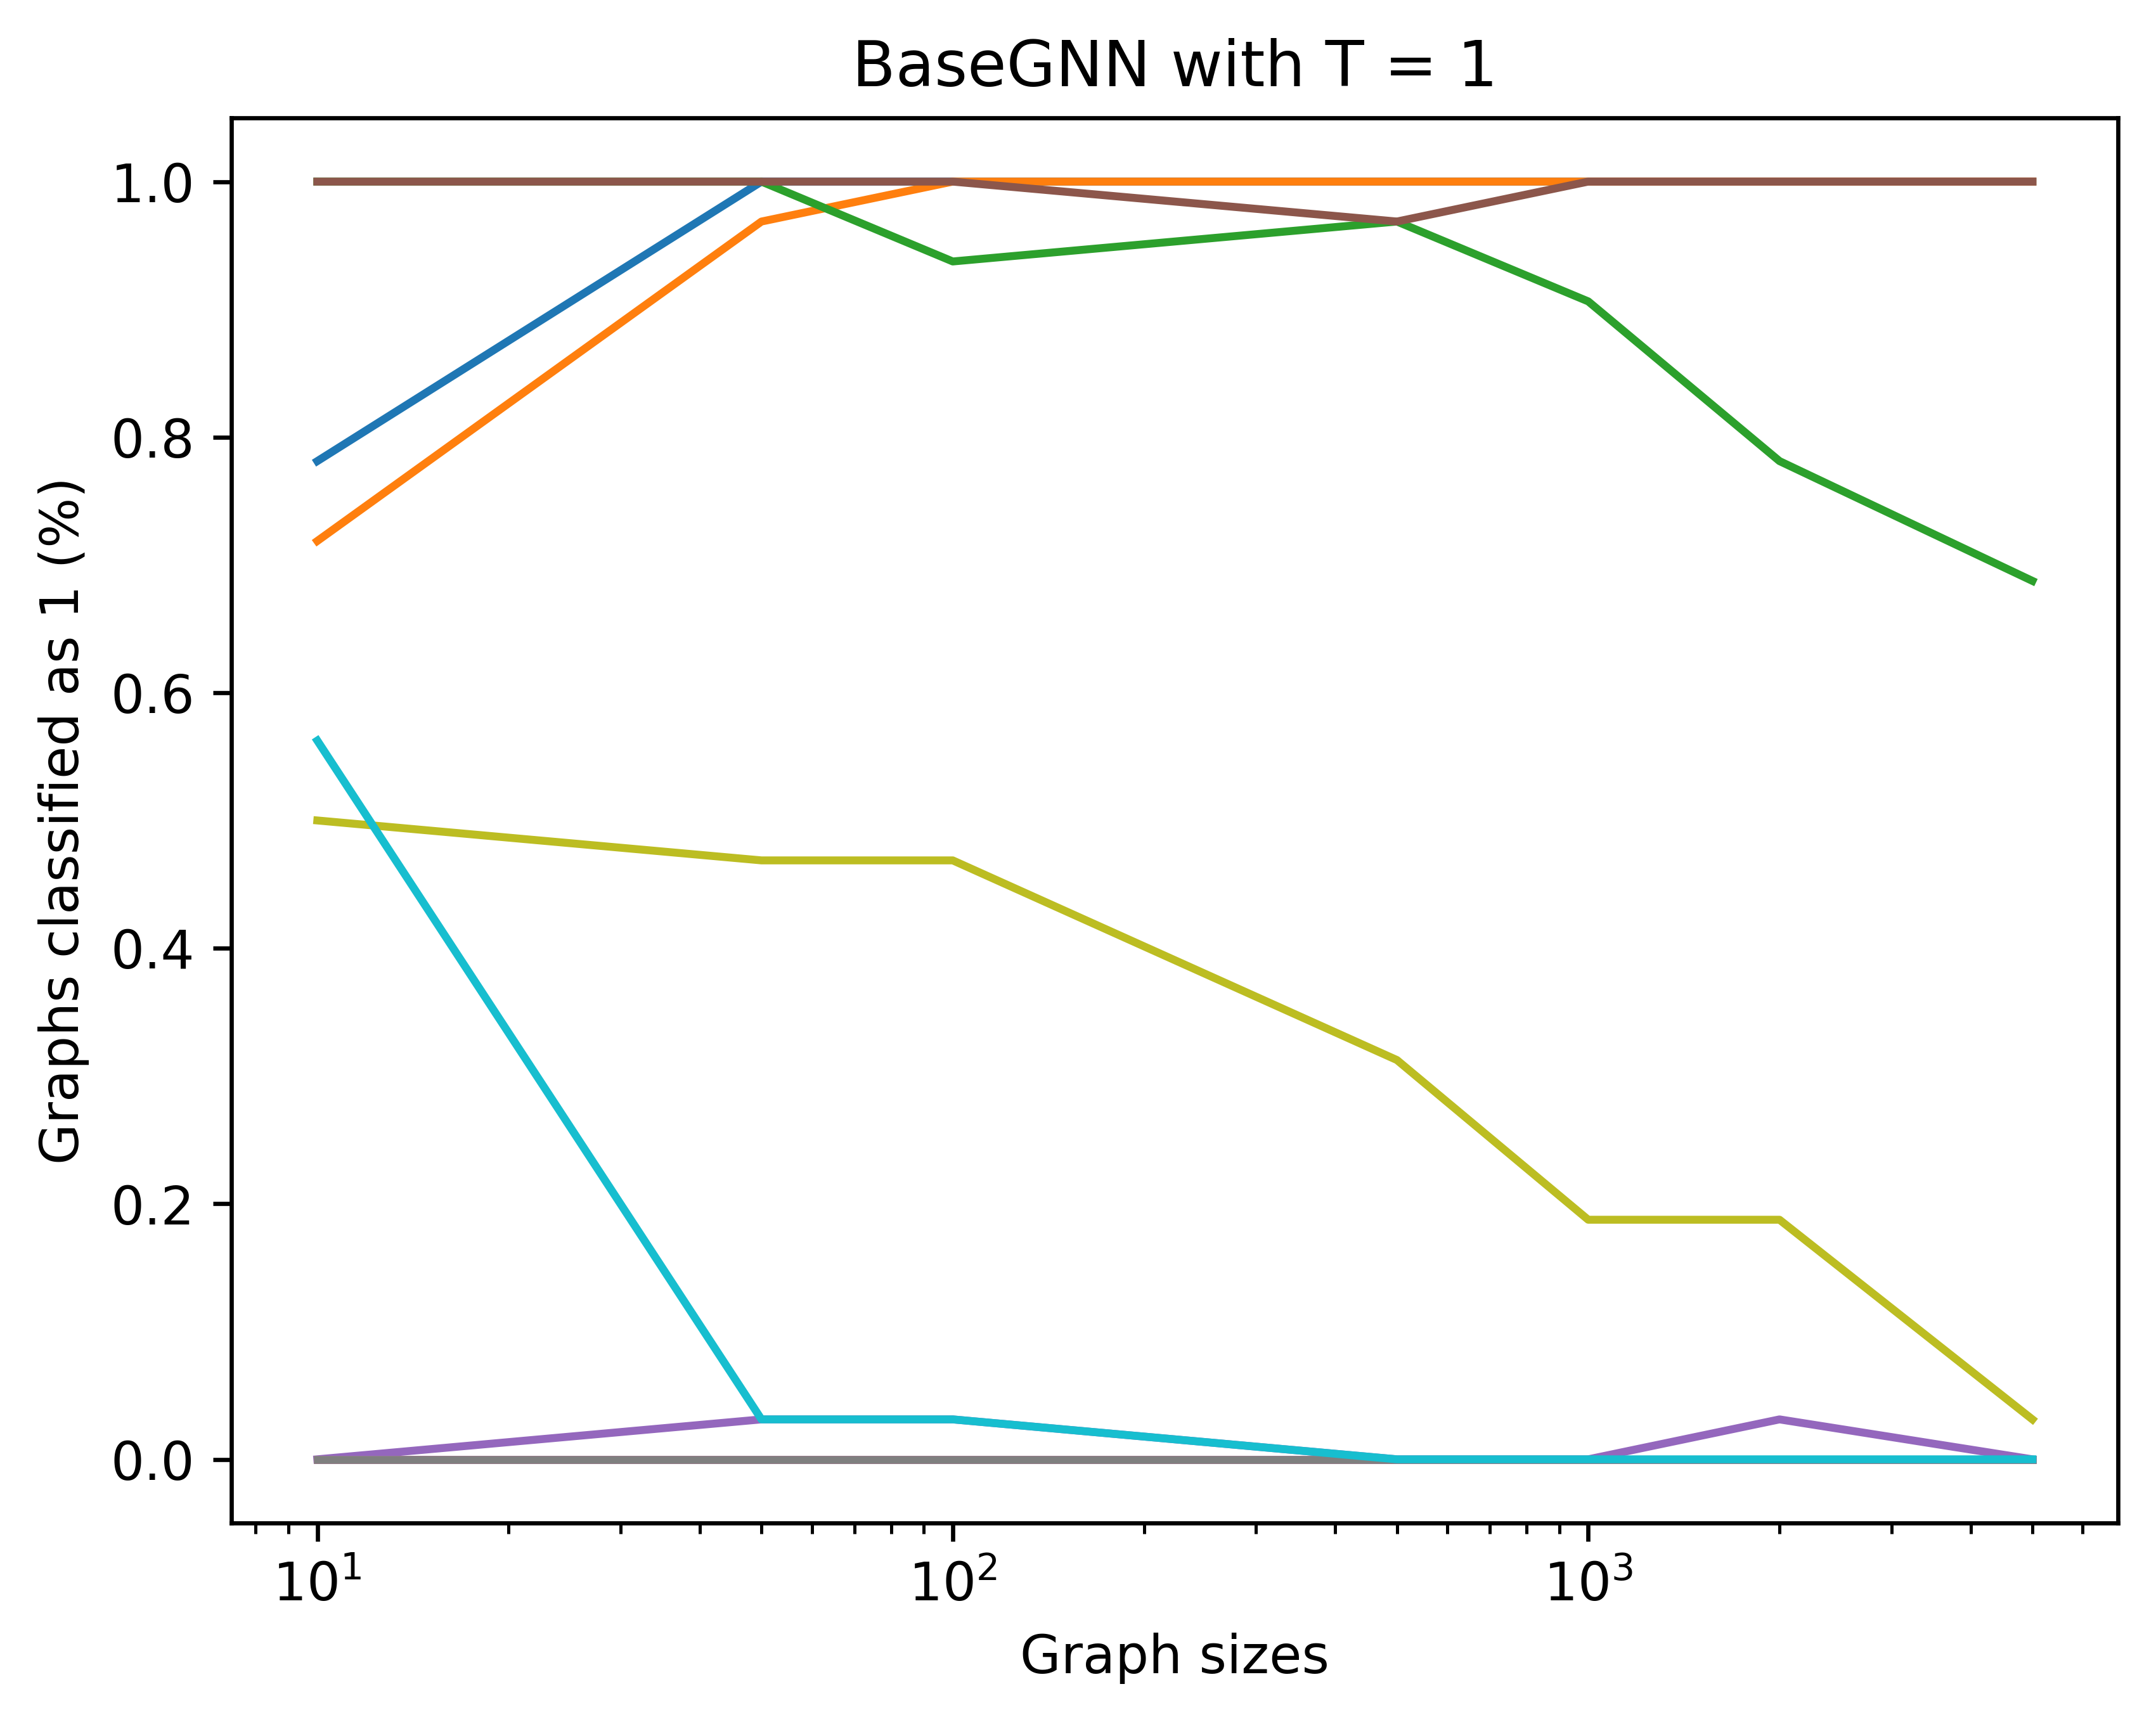

In [24]:
for y in csv_numLayer_1:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN with T = 1')
#plt.savefig('/Users/.../Desktop/.../visuals/sum_no_layers_1')
plt.show()

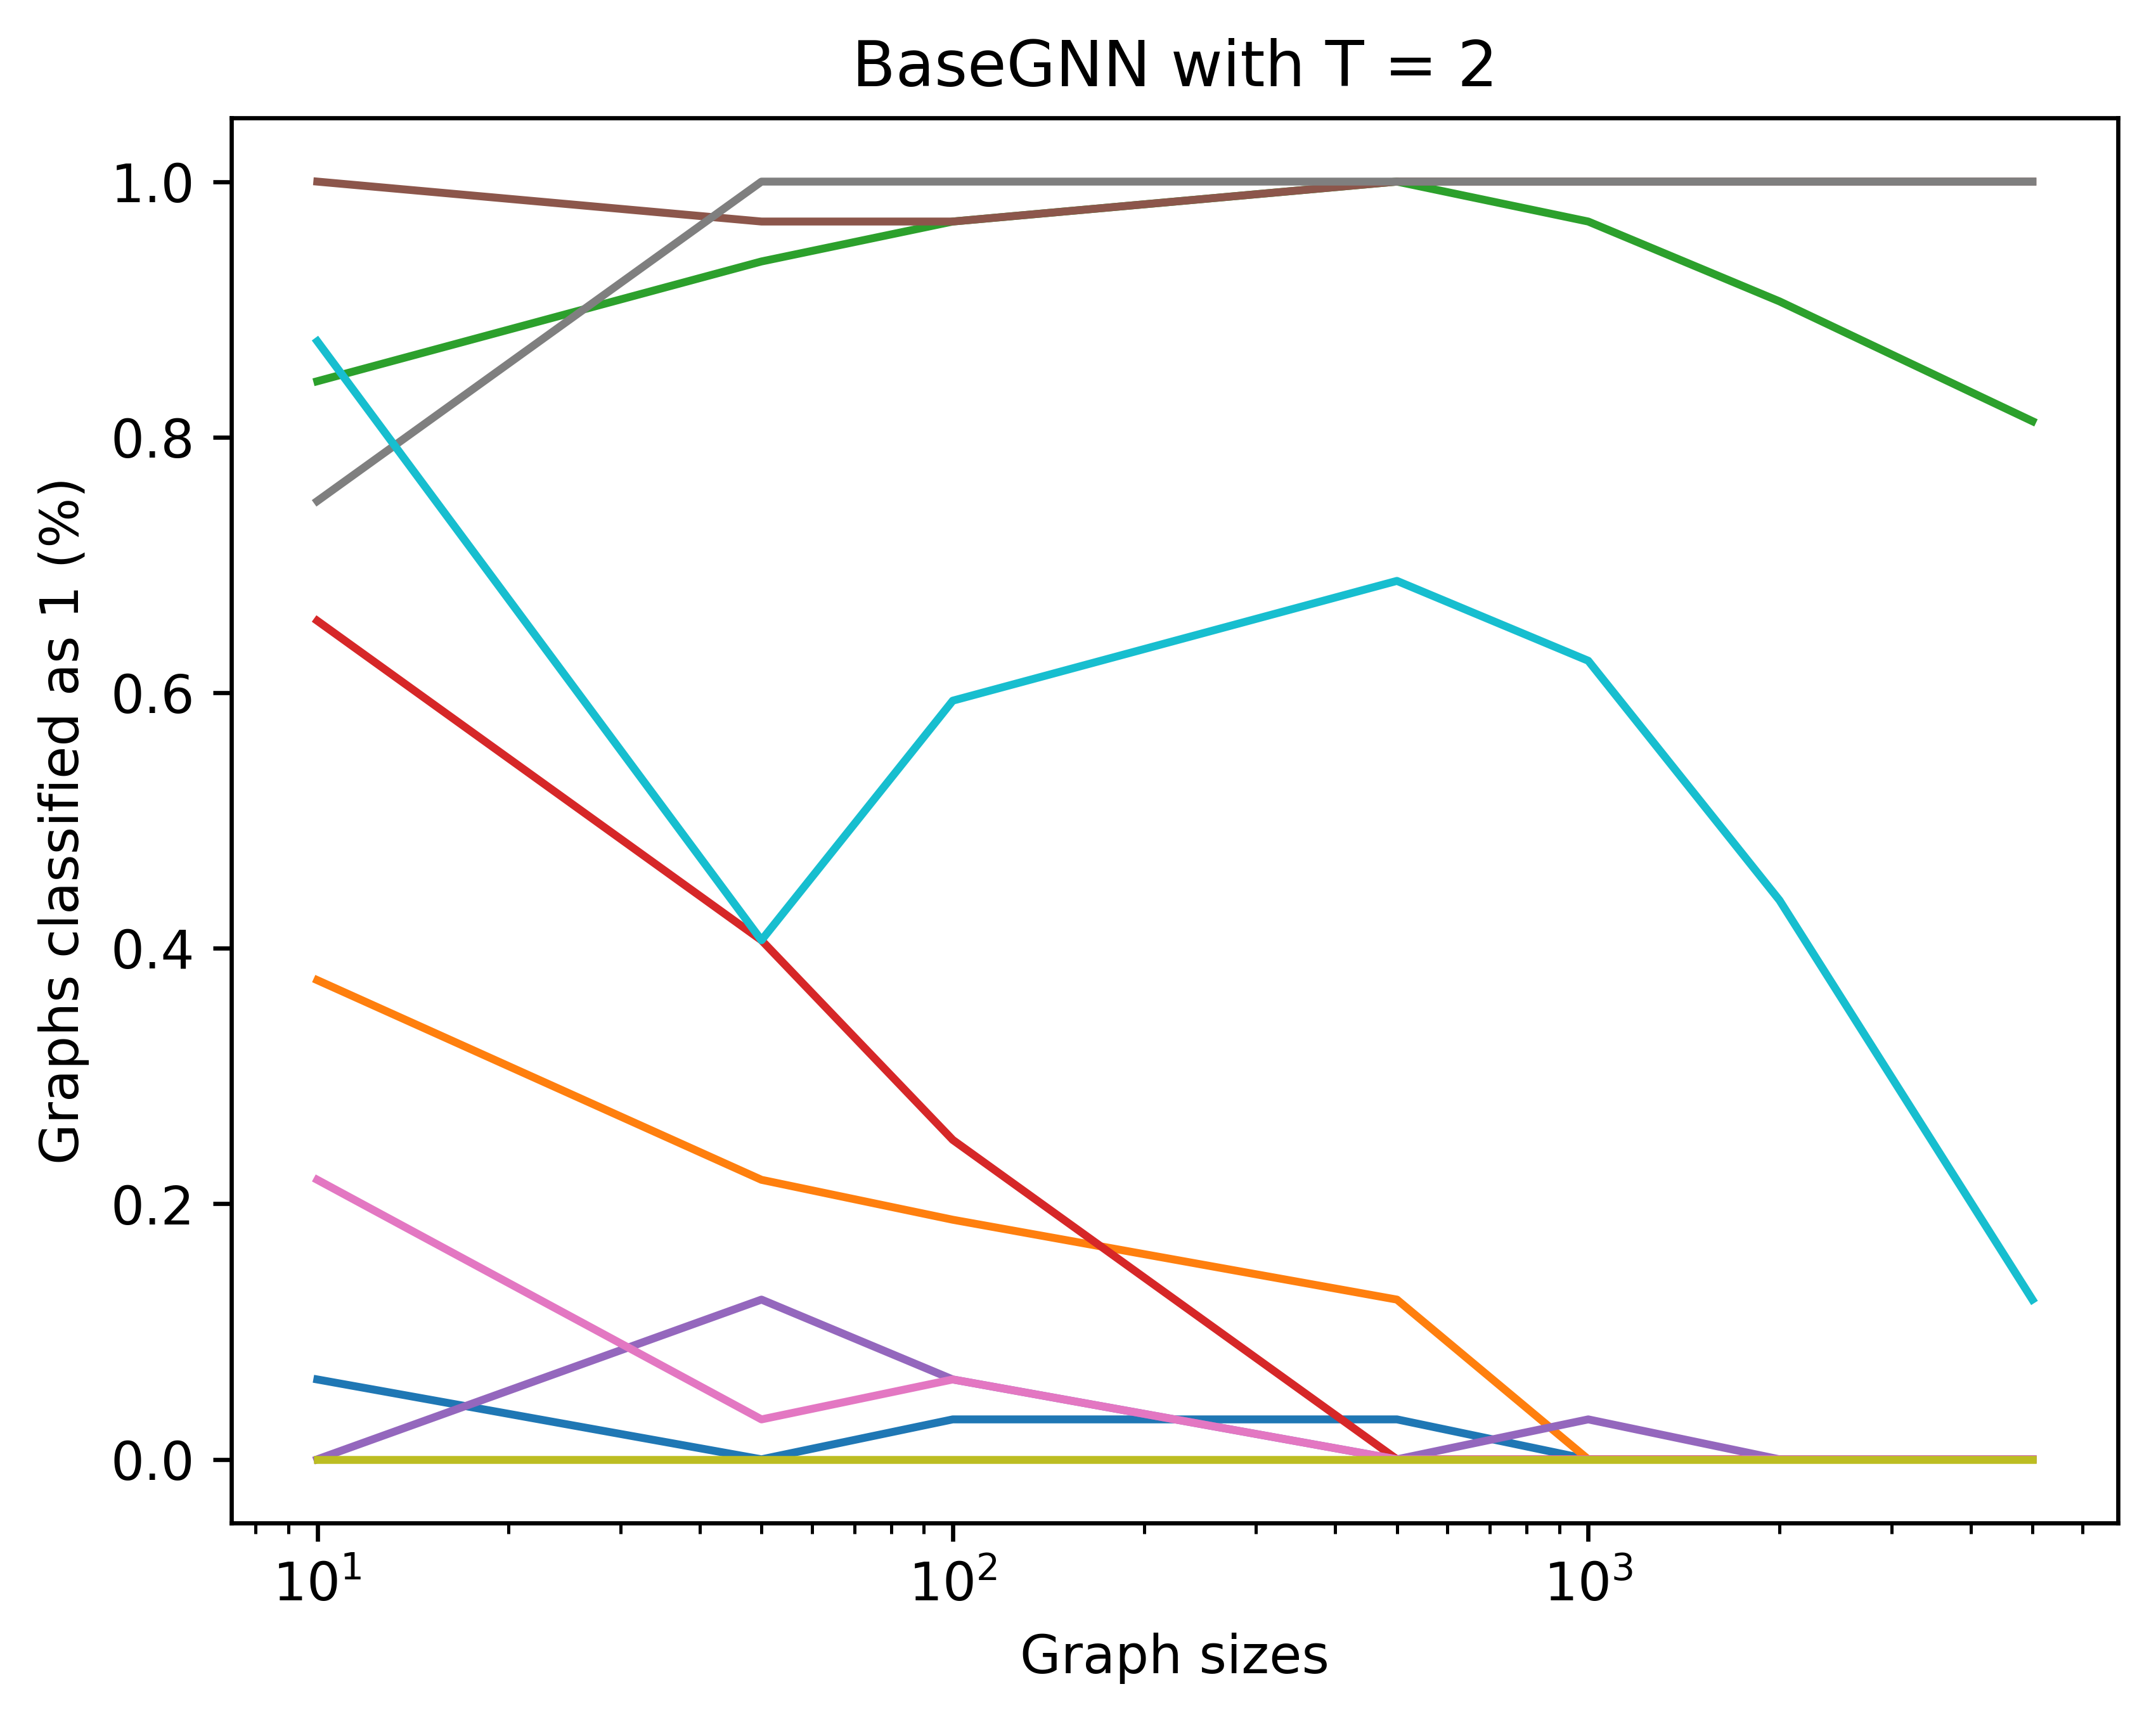

In [25]:
for y in csv_numLayer_2:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN with T = 2')
#plt.savefig('/Users/.../Desktop/.../visuals/sum_no_layers_2')
plt.show()

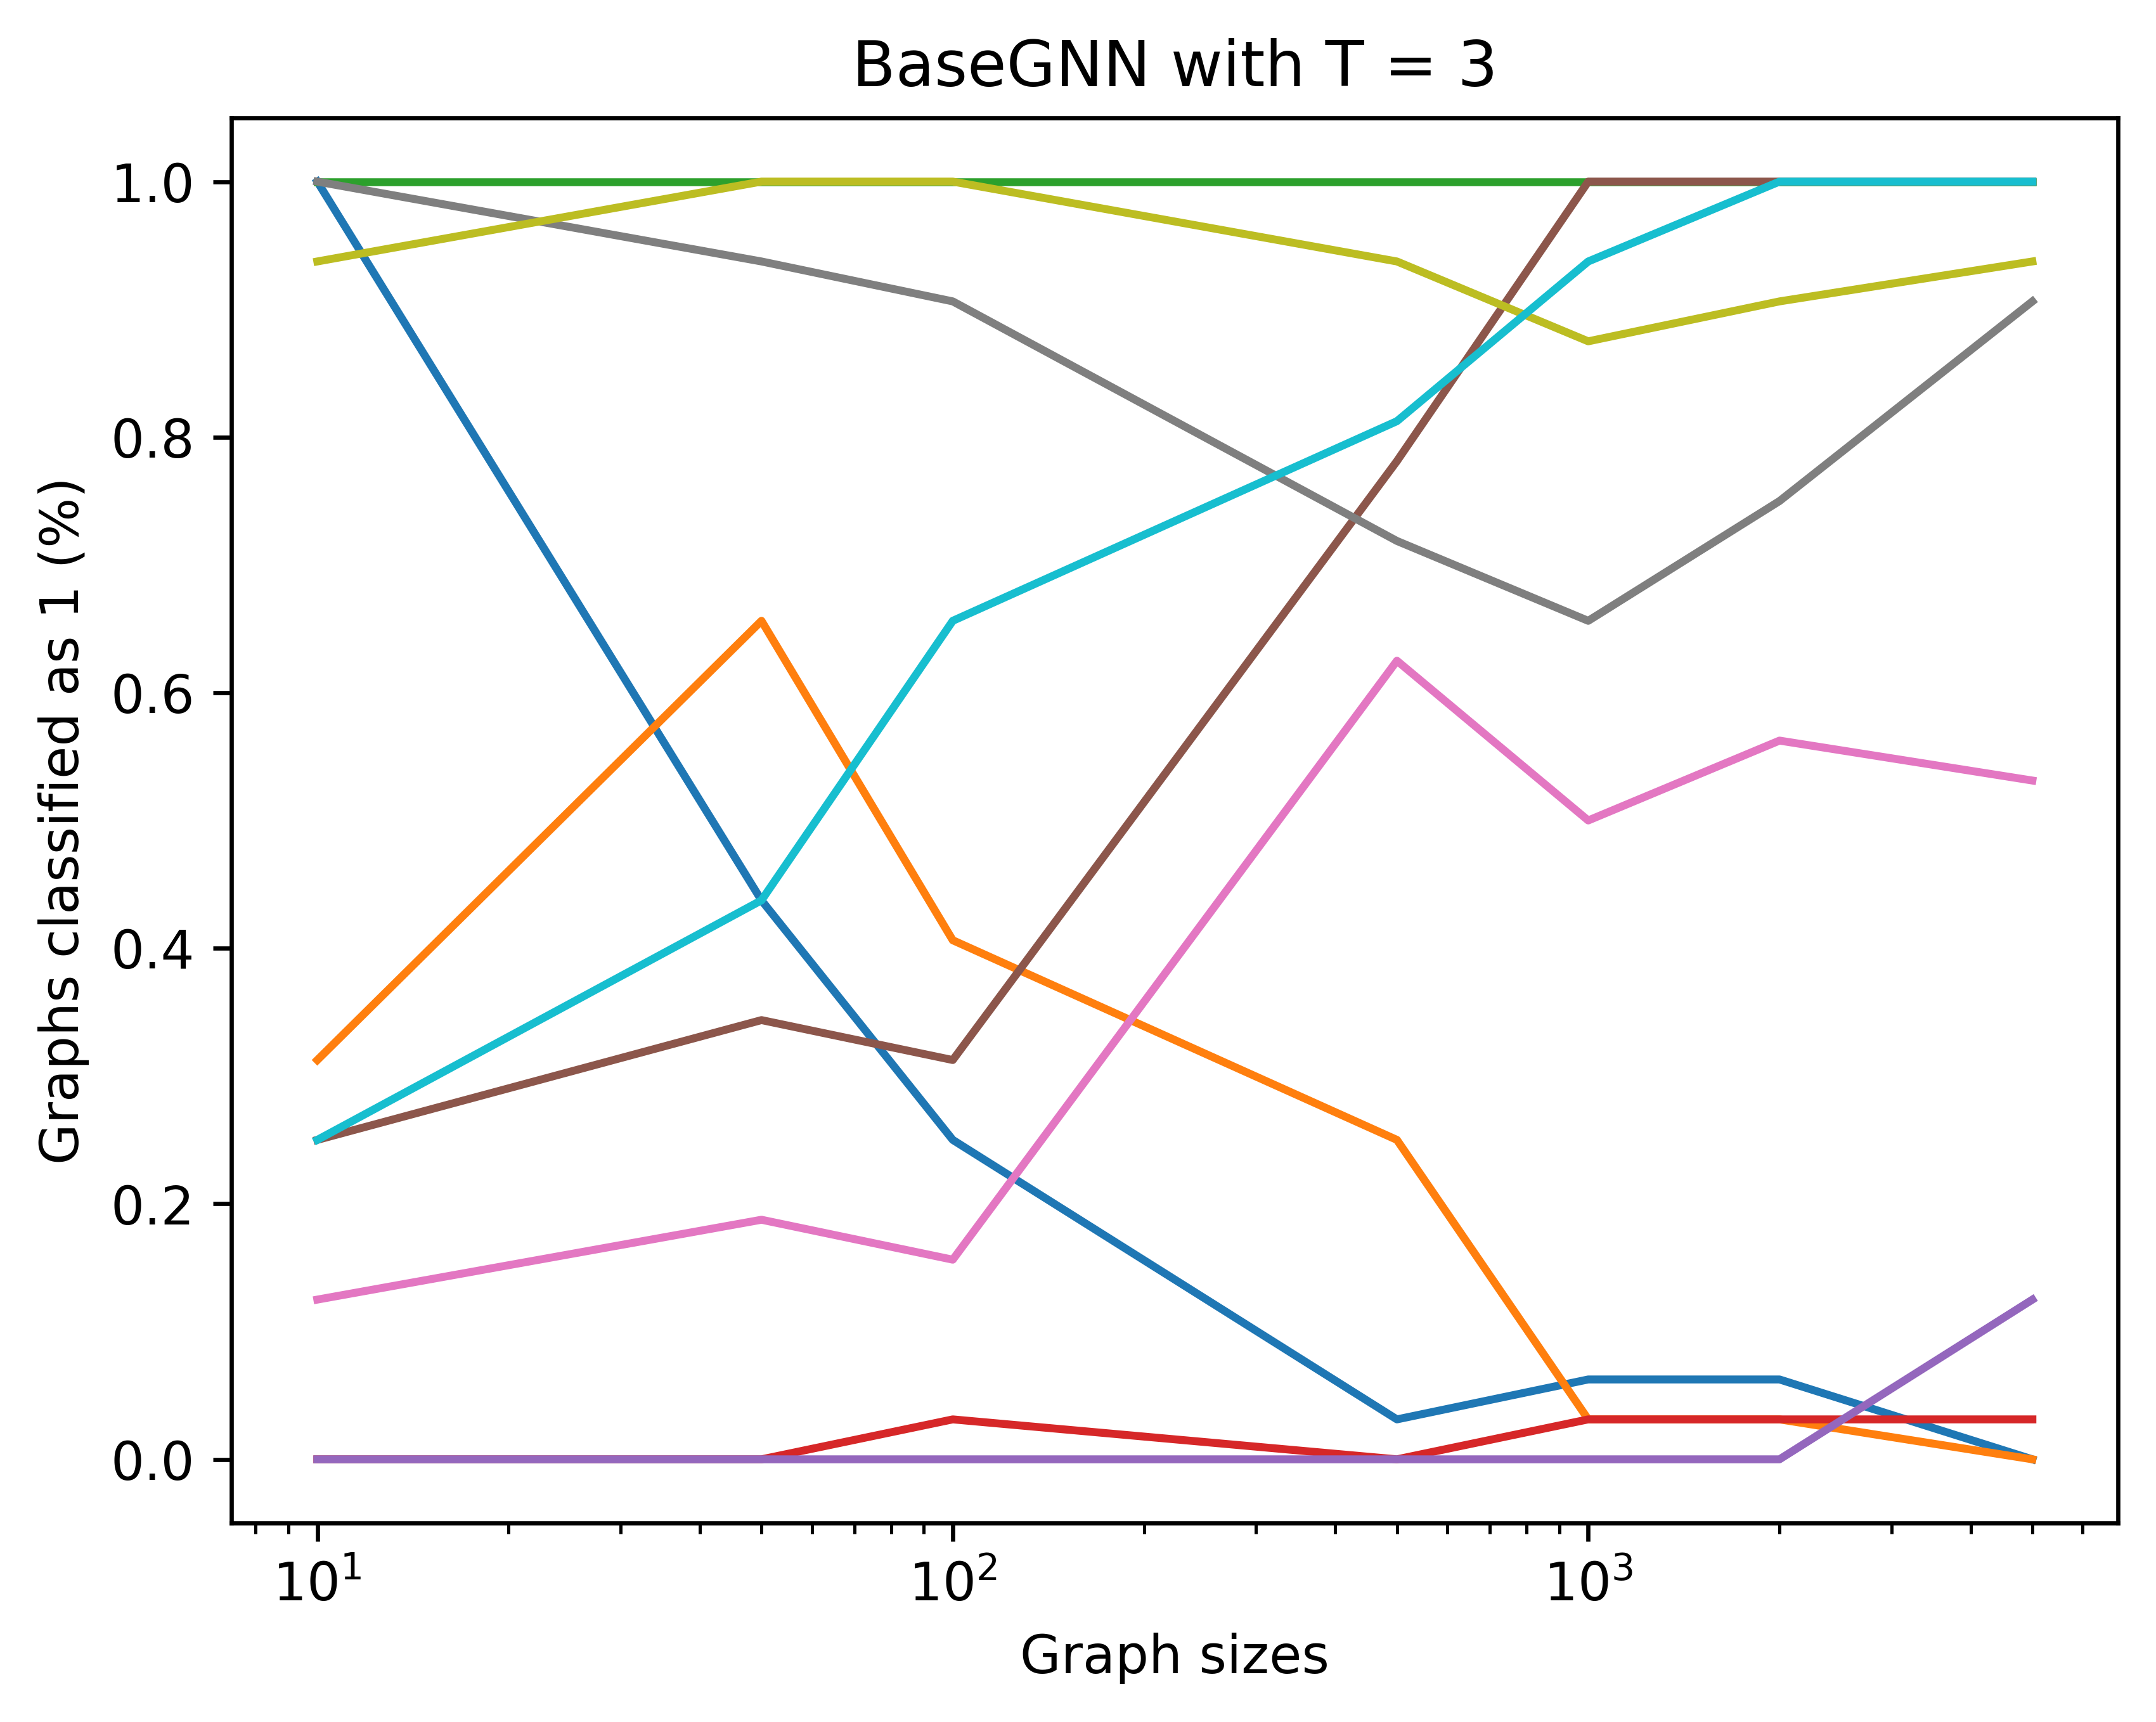

In [26]:
for y in csv_numLayer_3:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN with T = 3')
#plt.savefig('/Users/.../Desktop/.../visuals/sum_no_layers_3')
plt.show()

In [ ]:
import time
time.sleep(1000000)

KeyboardInterrupt: ignored

Add 50k

In [68]:
csv = []

for d in [64]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                #base_gnn = BaseGNNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         #num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                #mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            #num_layers=2, act_fn=torch.tanh)
                # Save Model
                base_gnn = torch.load(f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/base_gnn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                mlp = torch.load(f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                #torch.save(base_gnn,f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/base_gnn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                #torch.save(mlp,f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [50000]:

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = base_gnn(initial_node_feats, adj_matrix).mean(axis=0)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


[64, 0.5, 1, 0, [0]]
[64, 0.5, 1, 1, [32]]
[64, 0.5, 1, 2, [0]]
[64, 0.5, 1, 3, [0]]
[64, 0.5, 1, 4, [32]]
[64, 0.5, 1, 5, [0]]
[64, 0.5, 1, 6, [0]]
[64, 0.5, 1, 7, [32]]
[64, 0.5, 1, 8, [0]]
[64, 0.5, 1, 9, [32]]
[64, 0.5, 2, 0, [18]]
[64, 0.5, 2, 1, [0]]
[64, 0.5, 2, 2, [0]]
[64, 0.5, 2, 3, [0]]
[64, 0.5, 2, 4, [0]]
[64, 0.5, 2, 5, [32]]
[64, 0.5, 2, 6, [0]]
[64, 0.5, 2, 7, [32]]
[64, 0.5, 2, 8, [20]]
[64, 0.5, 2, 9, [0]]
[64, 0.5, 3, 0, [32]]
[64, 0.5, 3, 1, [2]]
[64, 0.5, 3, 2, [22]]
[64, 0.5, 3, 3, [0]]
[64, 0.5, 3, 4, [11]]
[64, 0.5, 3, 5, [32]]
[64, 0.5, 3, 6, [32]]
[64, 0.5, 3, 7, [1]]
[64, 0.5, 3, 8, [0]]
[64, 0.5, 3, 9, [32]]


In [72]:
ext_csv_numLayer_1 = [item[-1] for item in csv if item[2] == 1]
ext_csv_numLayer_2 = [item[-1] for item in csv if item[2] == 2]
ext_csv_numLayer_3 = [item[-1] for item in csv if item[2] == 3]

In [73]:
print(ext_csv_numLayer_1)
print(ext_csv_numLayer_2)
print(ext_csv_numLayer_3)

[[0], [32], [0], [0], [32], [0], [0], [32], [0], [32]]
[[18], [0], [0], [0], [0], [32], [0], [32], [20], [0]]
[[32], [2], [22], [0], [11], [32], [32], [1], [0], [32]]


In [74]:
x = [10, 50, 100, 500, 1000, 2000, 5000, 10000, 15000, 20000, 50000]

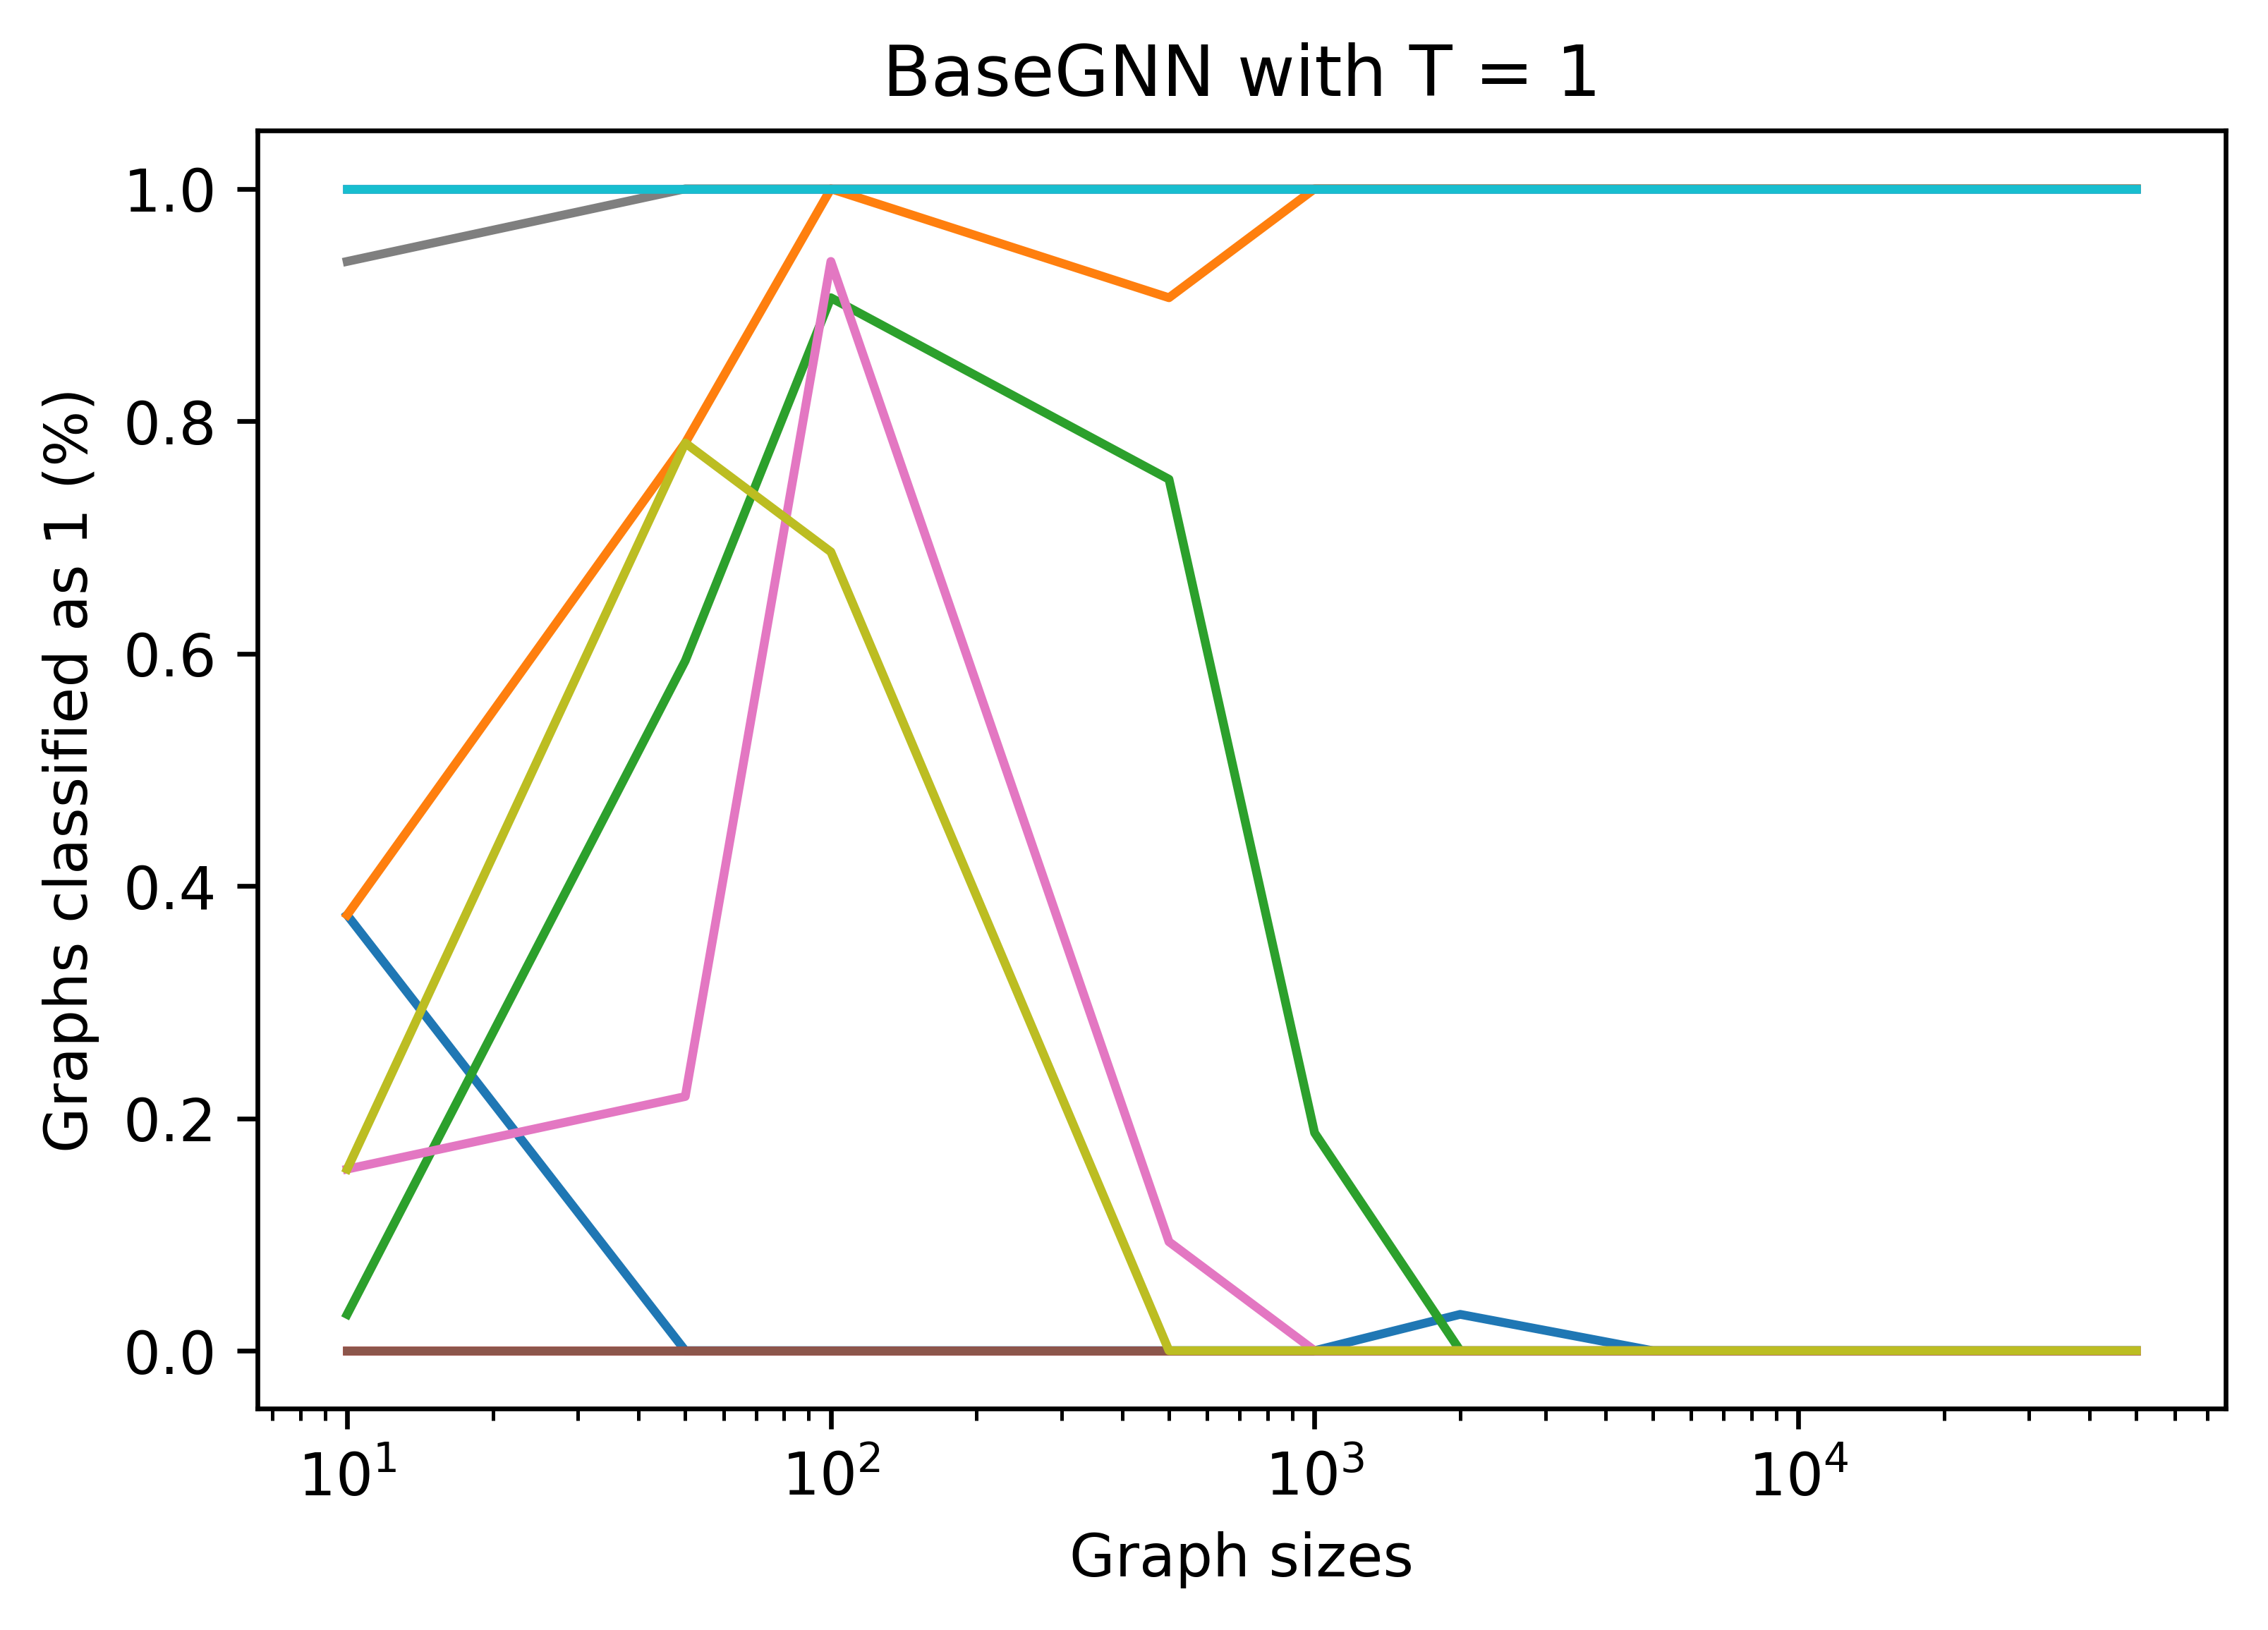

In [78]:
for idx,y in enumerate(csv_numLayer_1):
  y = [item/32 for item in y] + [ext_csv_numLayer_1[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN with T = 1')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/Added_BaseGNN with T = 1')
plt.show()

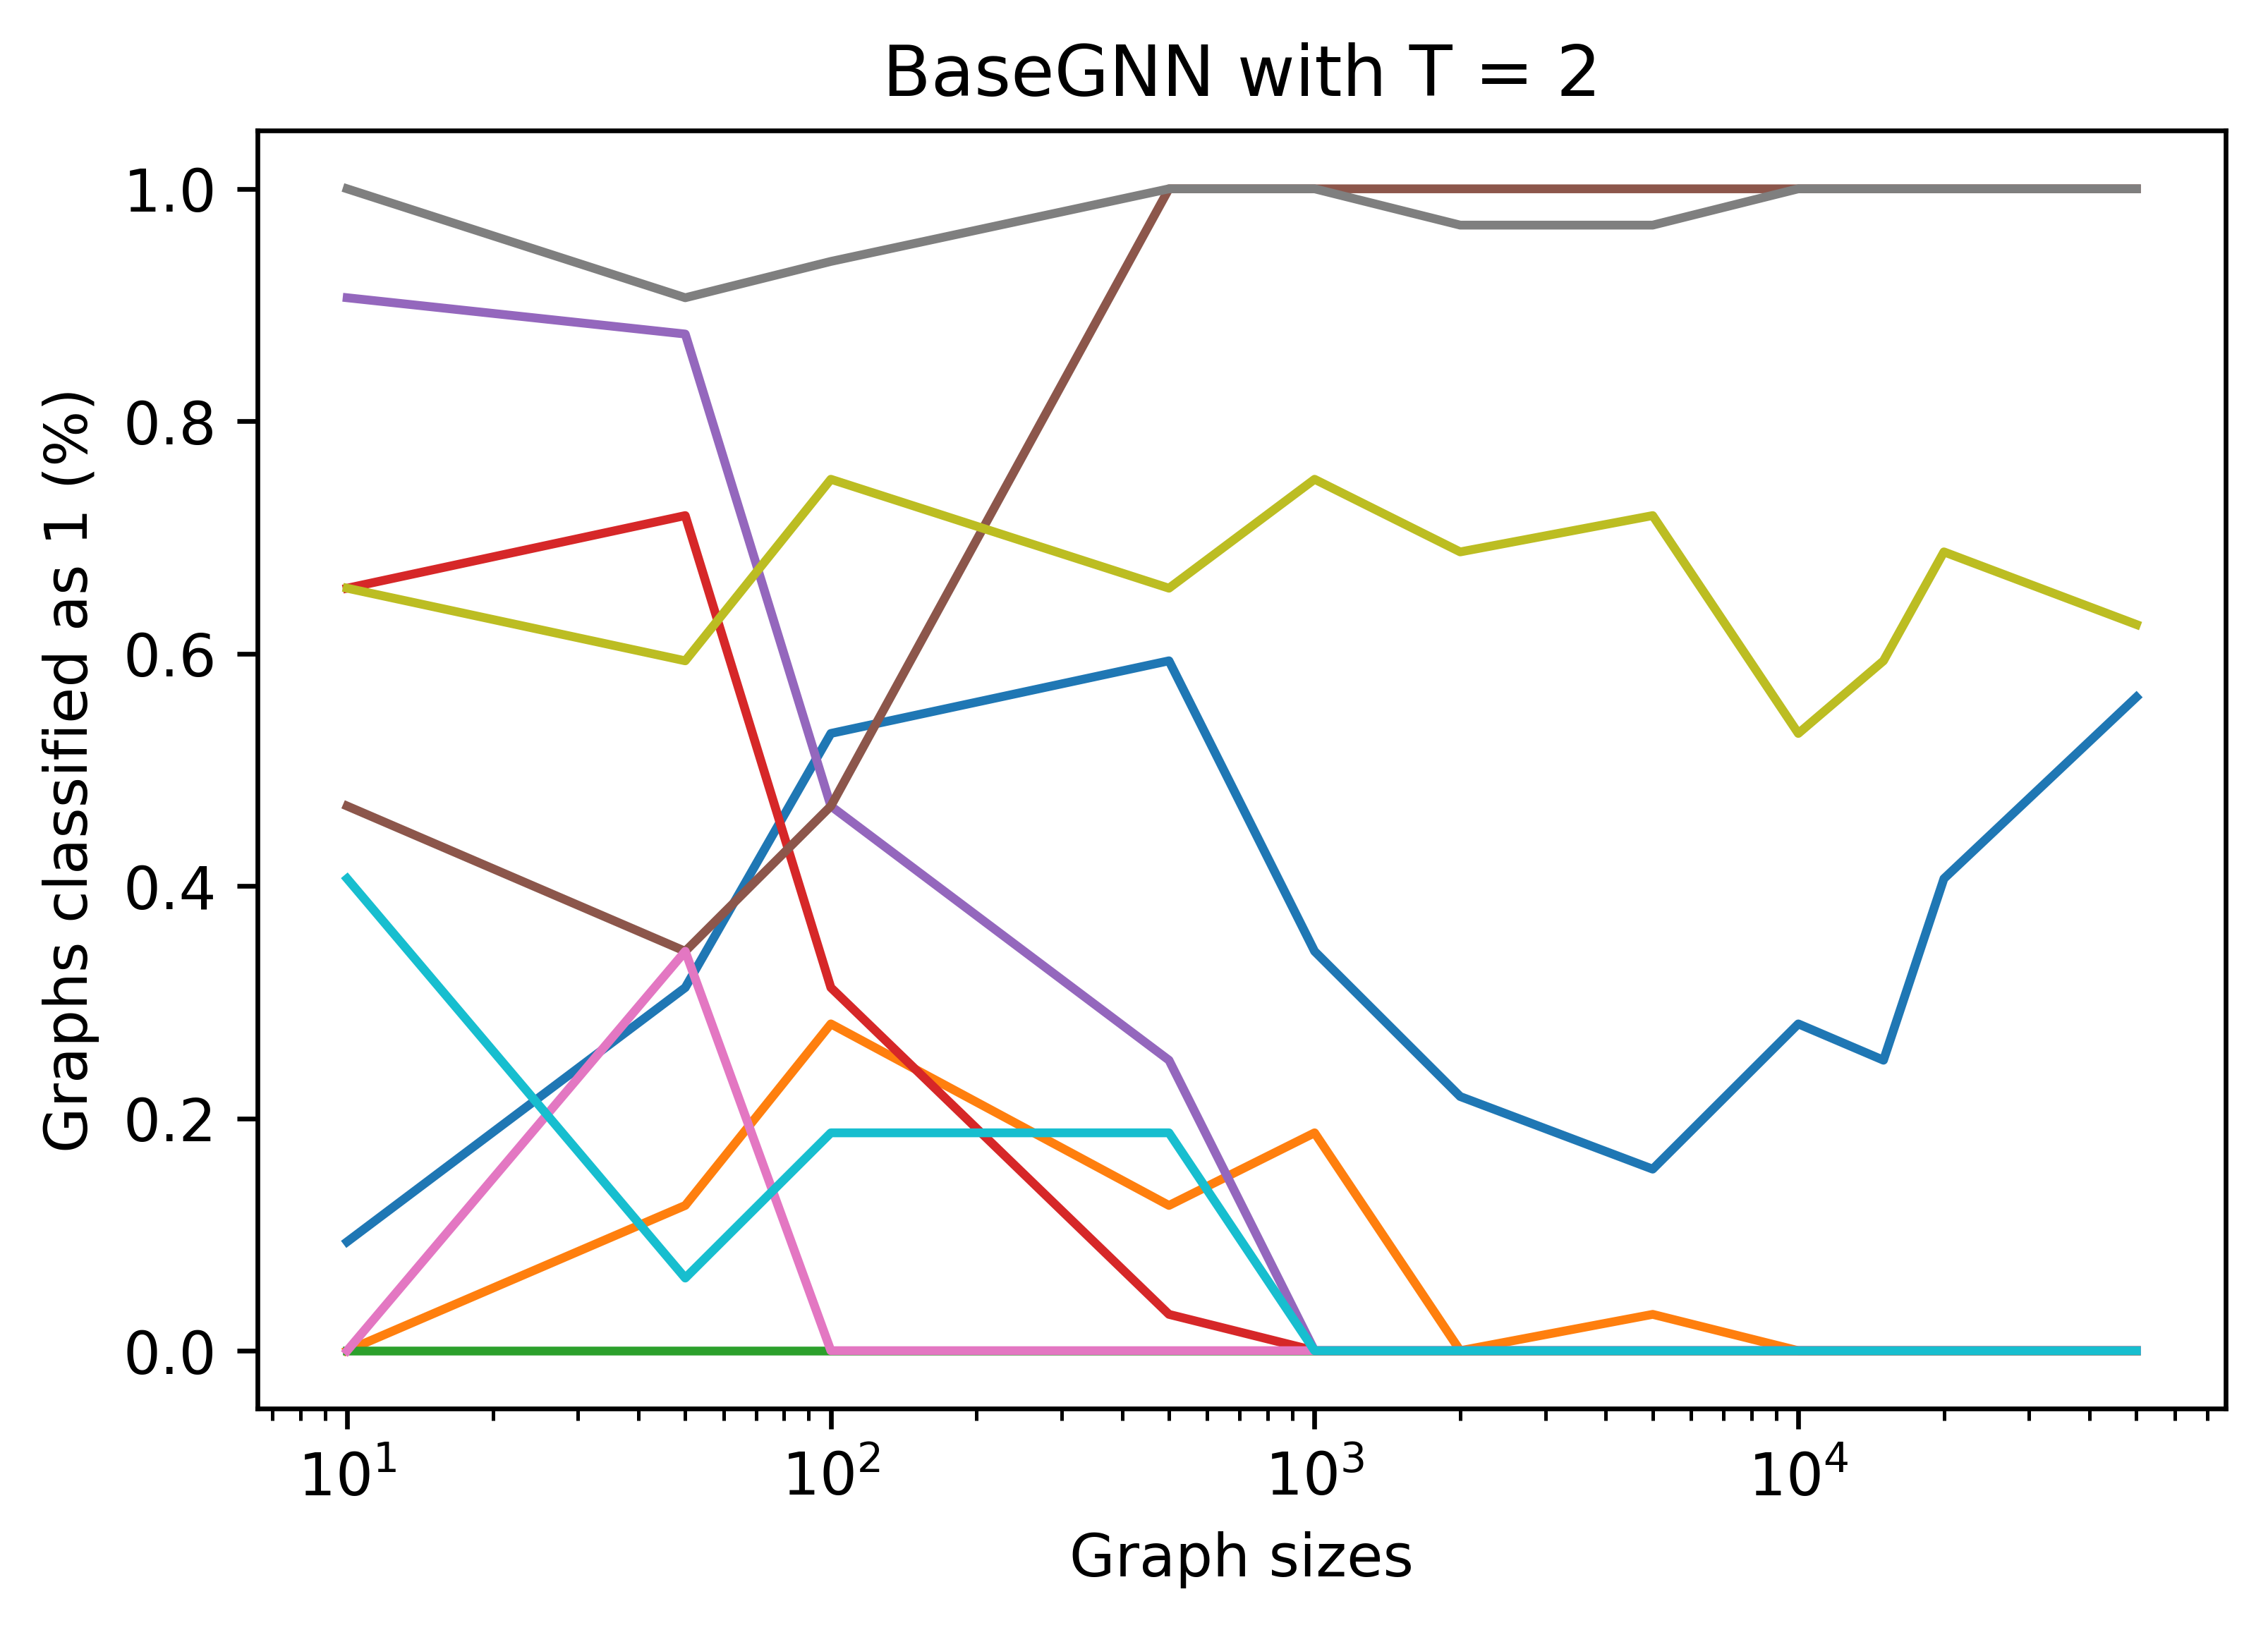

In [79]:
for idx,y in enumerate(csv_numLayer_2):
  y = [item/32 for item in y] + [ext_csv_numLayer_2[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN with T = 2')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/Added_BaseGNN with T = 2')
plt.show()

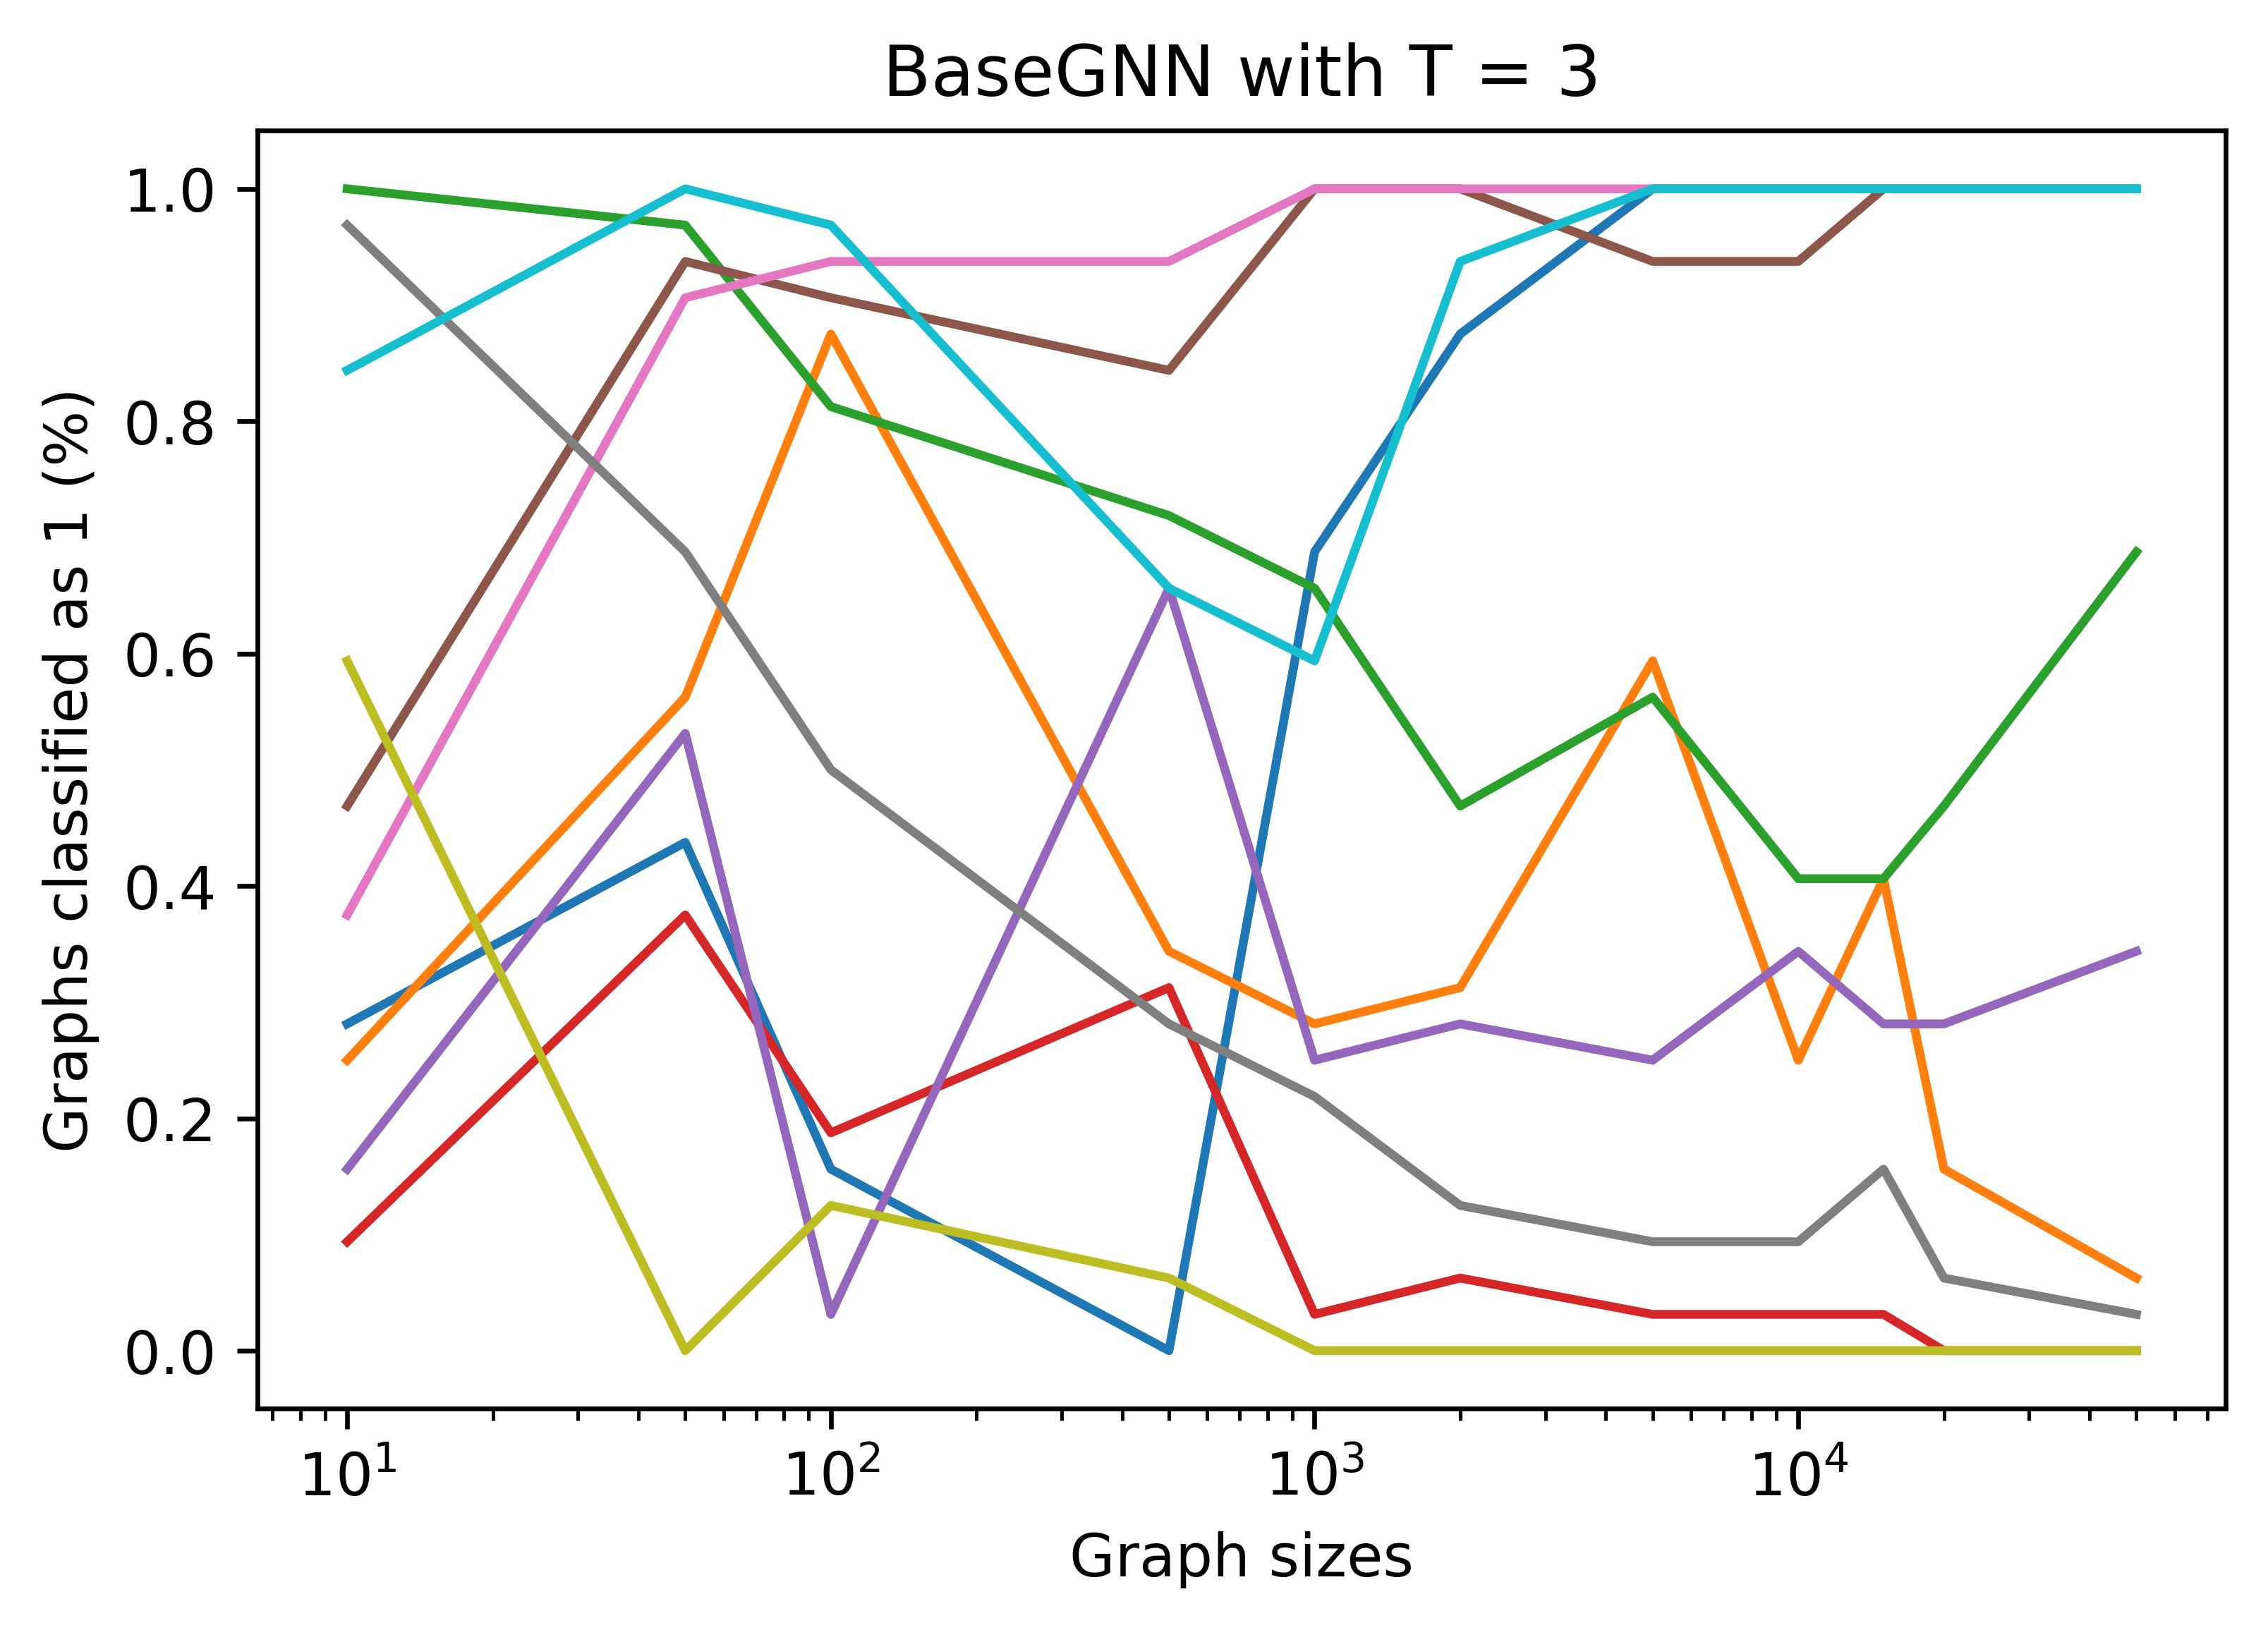

In [80]:
for idx,y in enumerate(csv_numLayer_3):
  y = [item/32 for item in y] + [ext_csv_numLayer_3[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN with T = 3')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/Added_BaseGNN with T = 3')
plt.show()

In [ ]:
import time
time.sleep(1000000)

Rename and Remove

In [22]:
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

In [23]:
ext_csv_numLayer_1 = [[0], [32], [0], [0], [32], [0], [0], [32], [0], [32]]
ext_csv_numLayer_2  = [[18], [0], [0], [0], [0], [32], [0], [32], [20], [0]]
ext_csv_numLayer_3 = [[32], [2], [22], [0], [11], [32], [32], [1], [0], [32]]

In [24]:
path_1 = f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/base_gnn_num_1.pickle"
with open(path_1, 'rb') as handle:
    csv_numLayer_1 = pickle.load(handle)

path_2 = f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/base_gnn_num_2.pickle"
with open(path_2, 'rb') as handle:
    csv_numLayer_2 = pickle.load(handle)

path_3 = f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/base_gnn_num_3.pickle"
with open(path_3, 'rb') as handle:
    csv_numLayer_3 = pickle.load(handle)

In [25]:
x = [10, 50, 100, 500, 1000, 2000, 5000, 10000, 15000, 20000, 50000]

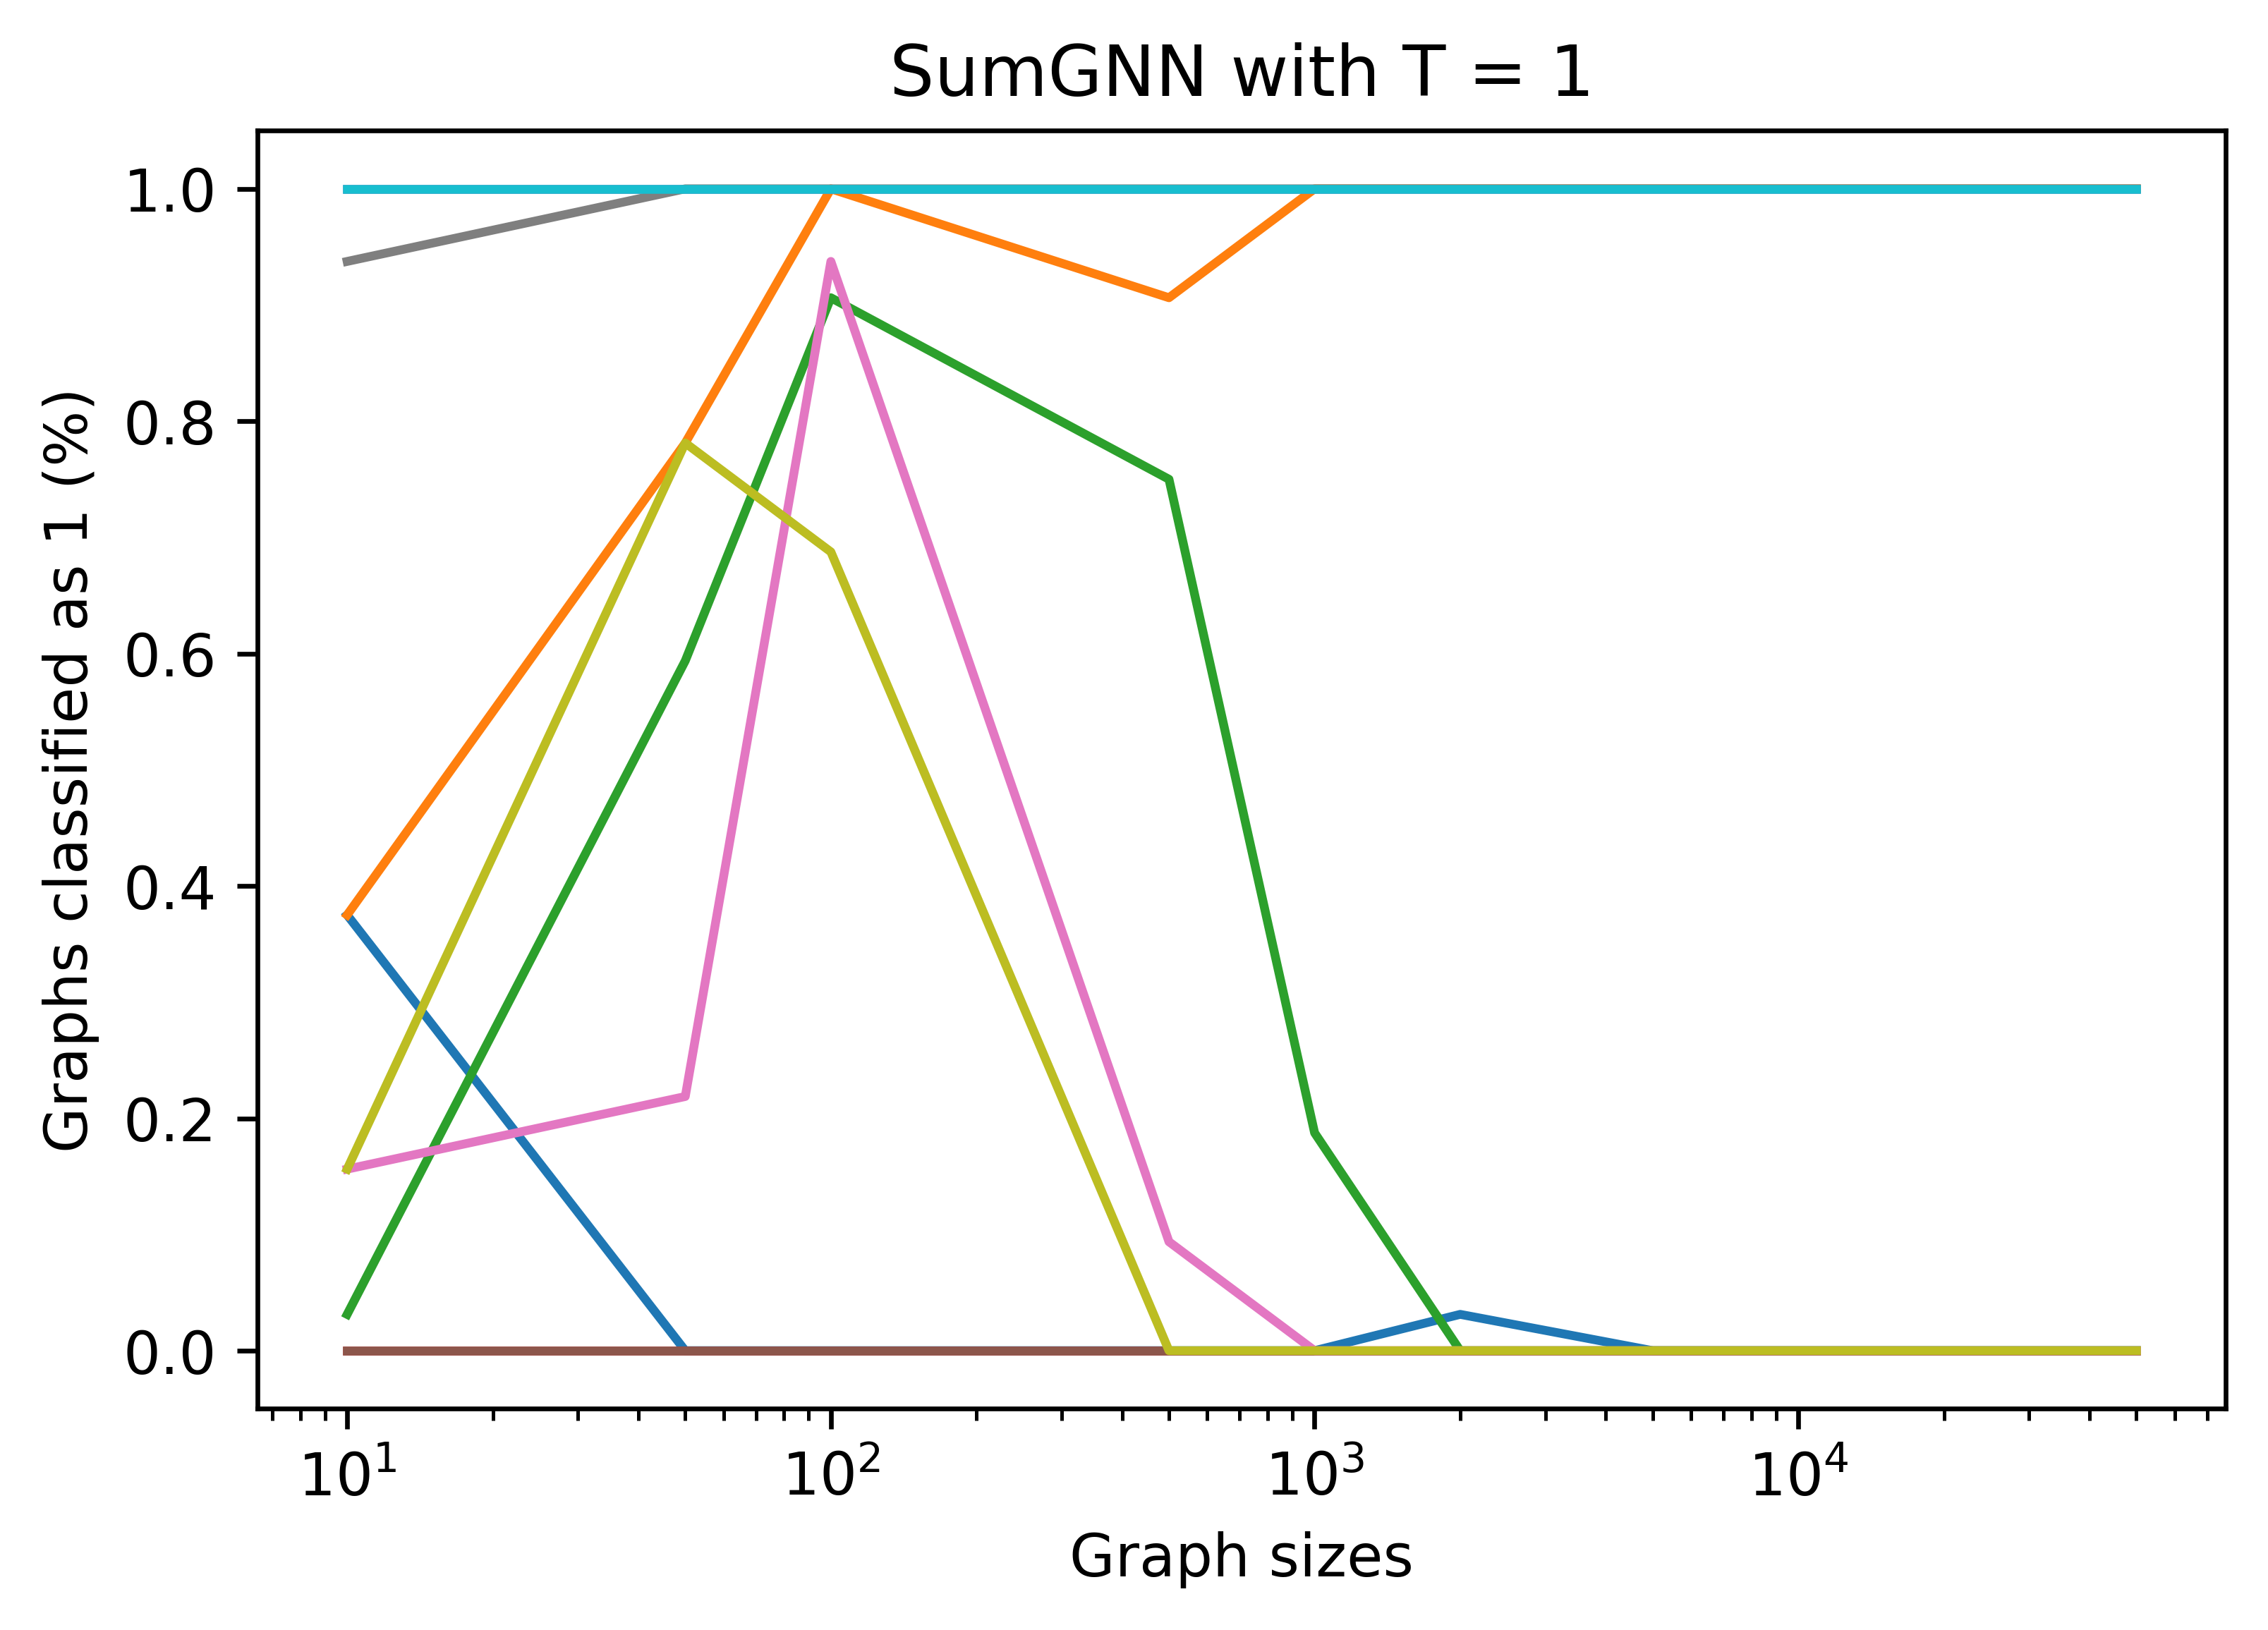

In [26]:
for idx,y in enumerate(csv_numLayer_1):
  y = [item/32 for item in y] + [ext_csv_numLayer_1[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN with T = 1')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/Added_SumGNN with T = 1')
plt.show()

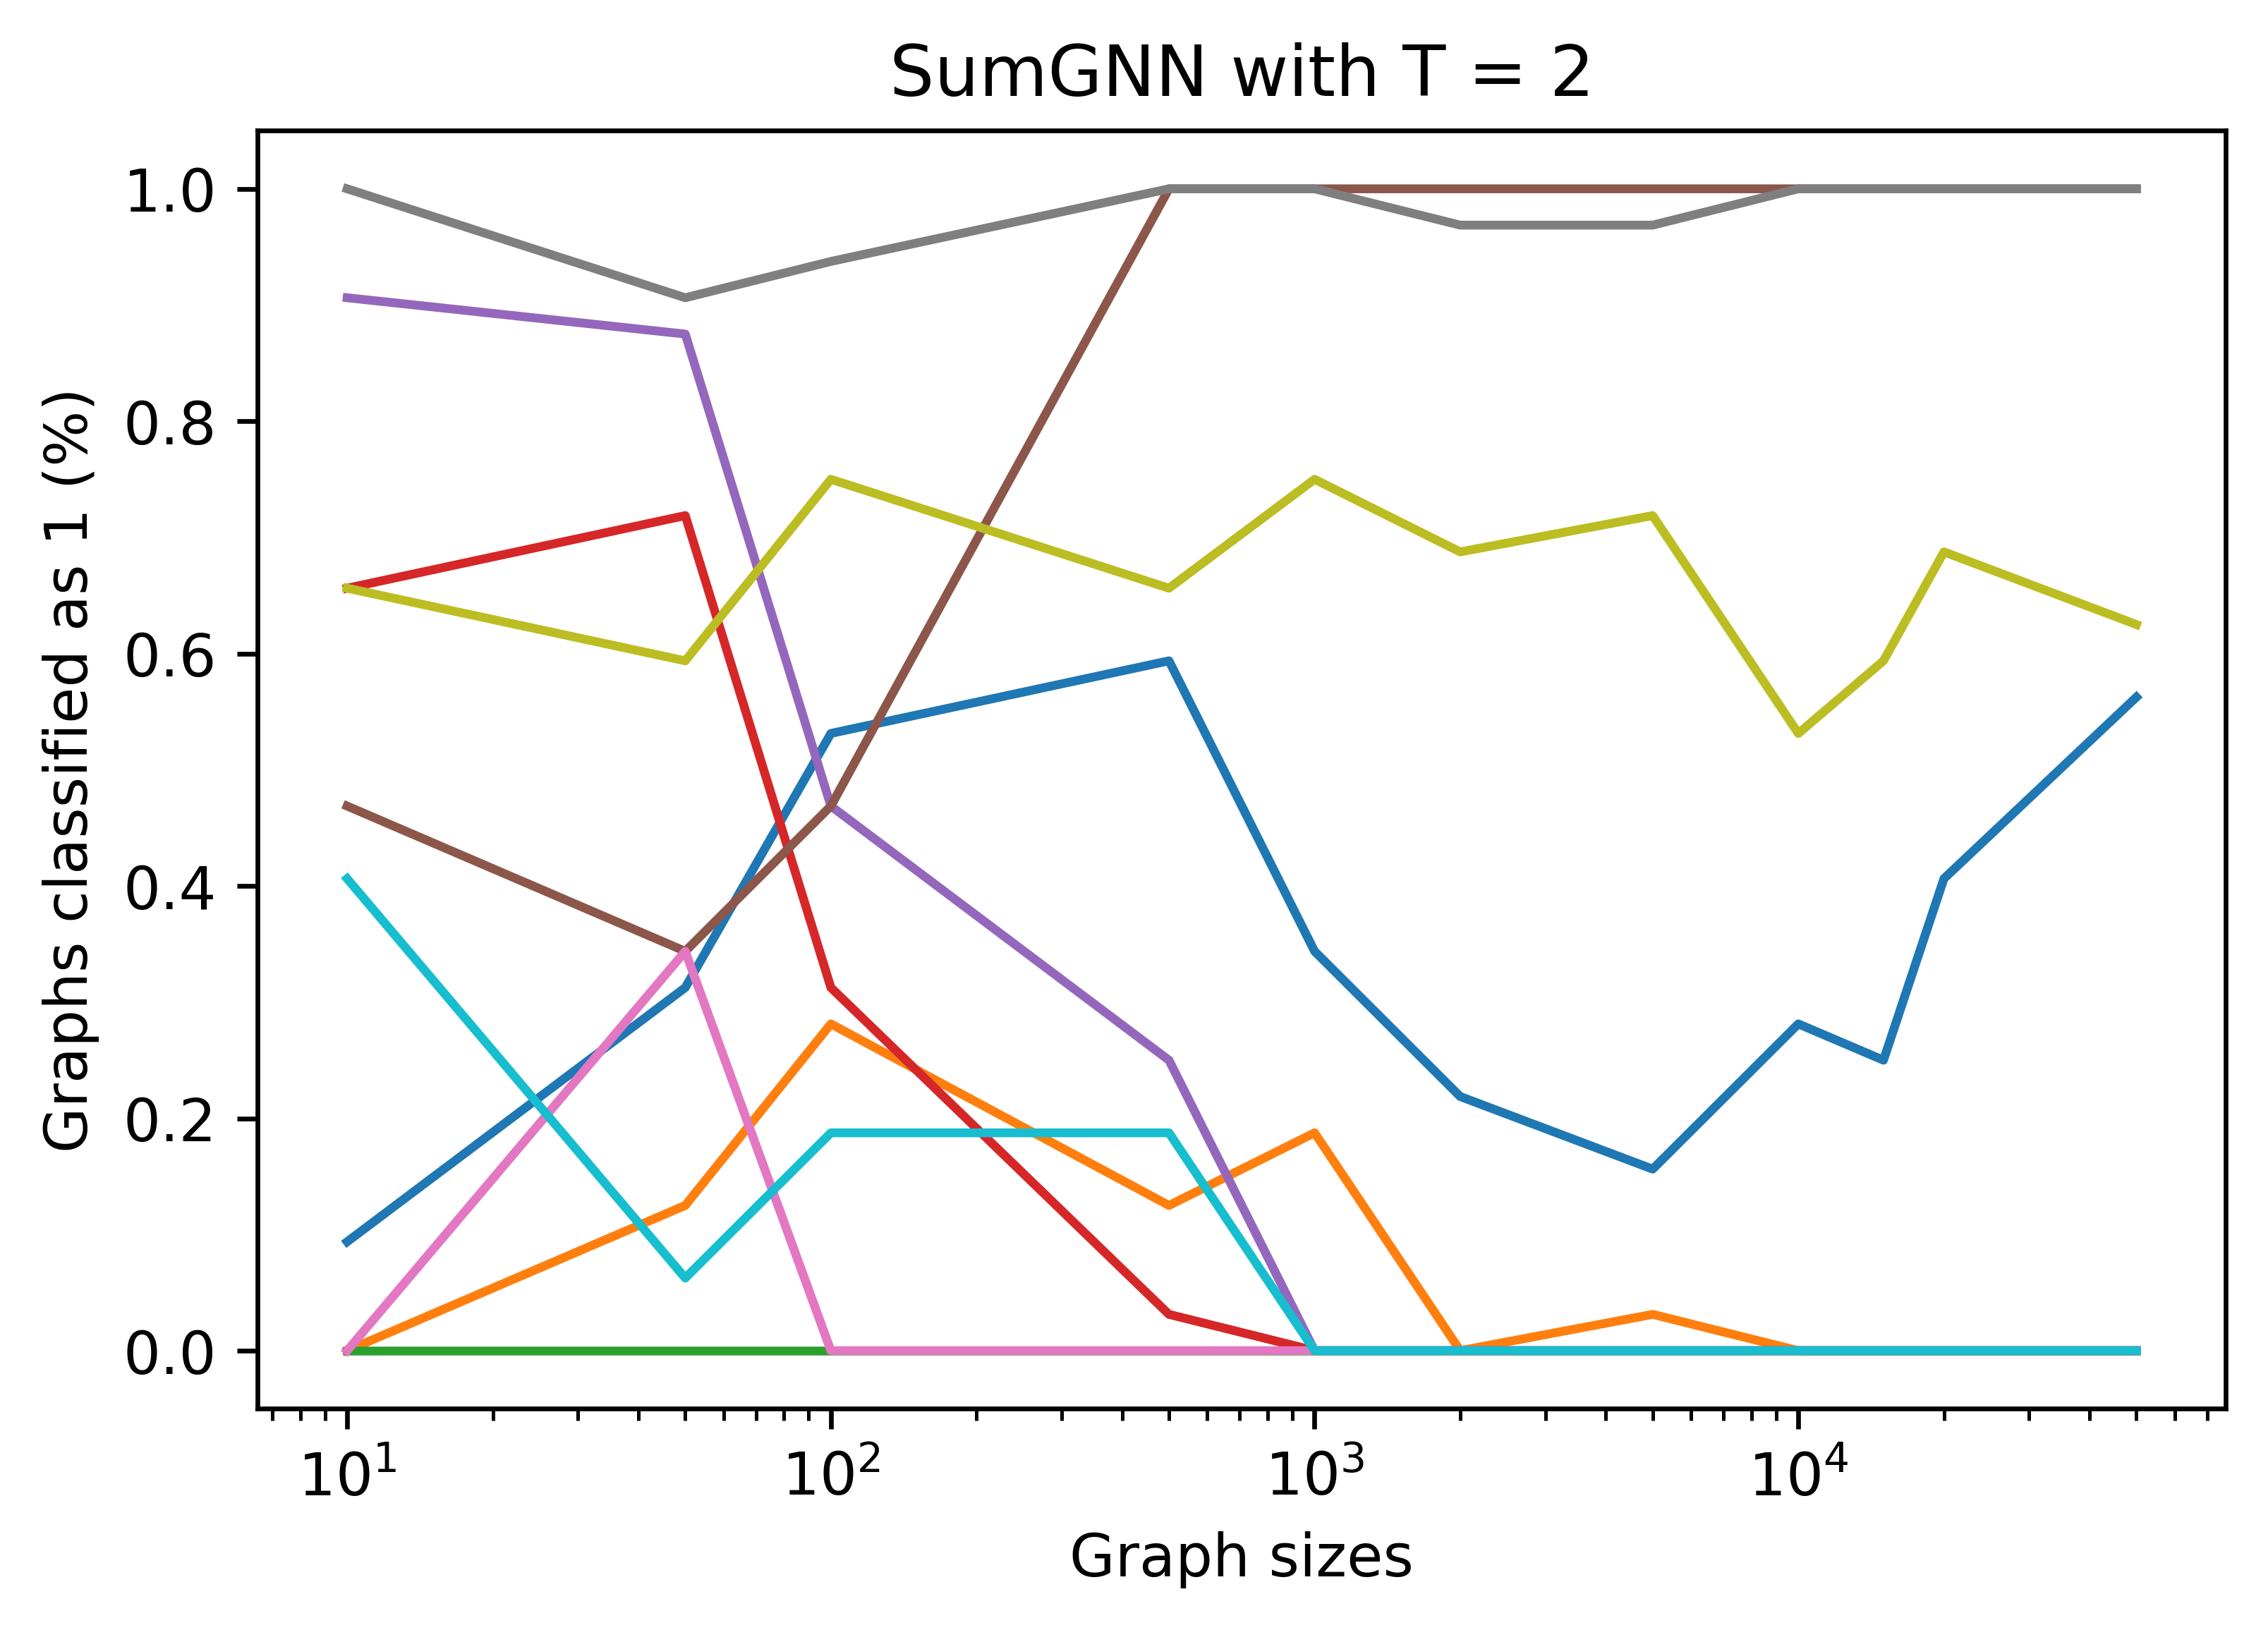

In [27]:
for idx,y in enumerate(csv_numLayer_2):
  y = [item/32 for item in y] + [ext_csv_numLayer_2[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN with T = 2')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/Added_SumGNN with T = 2')
plt.show()

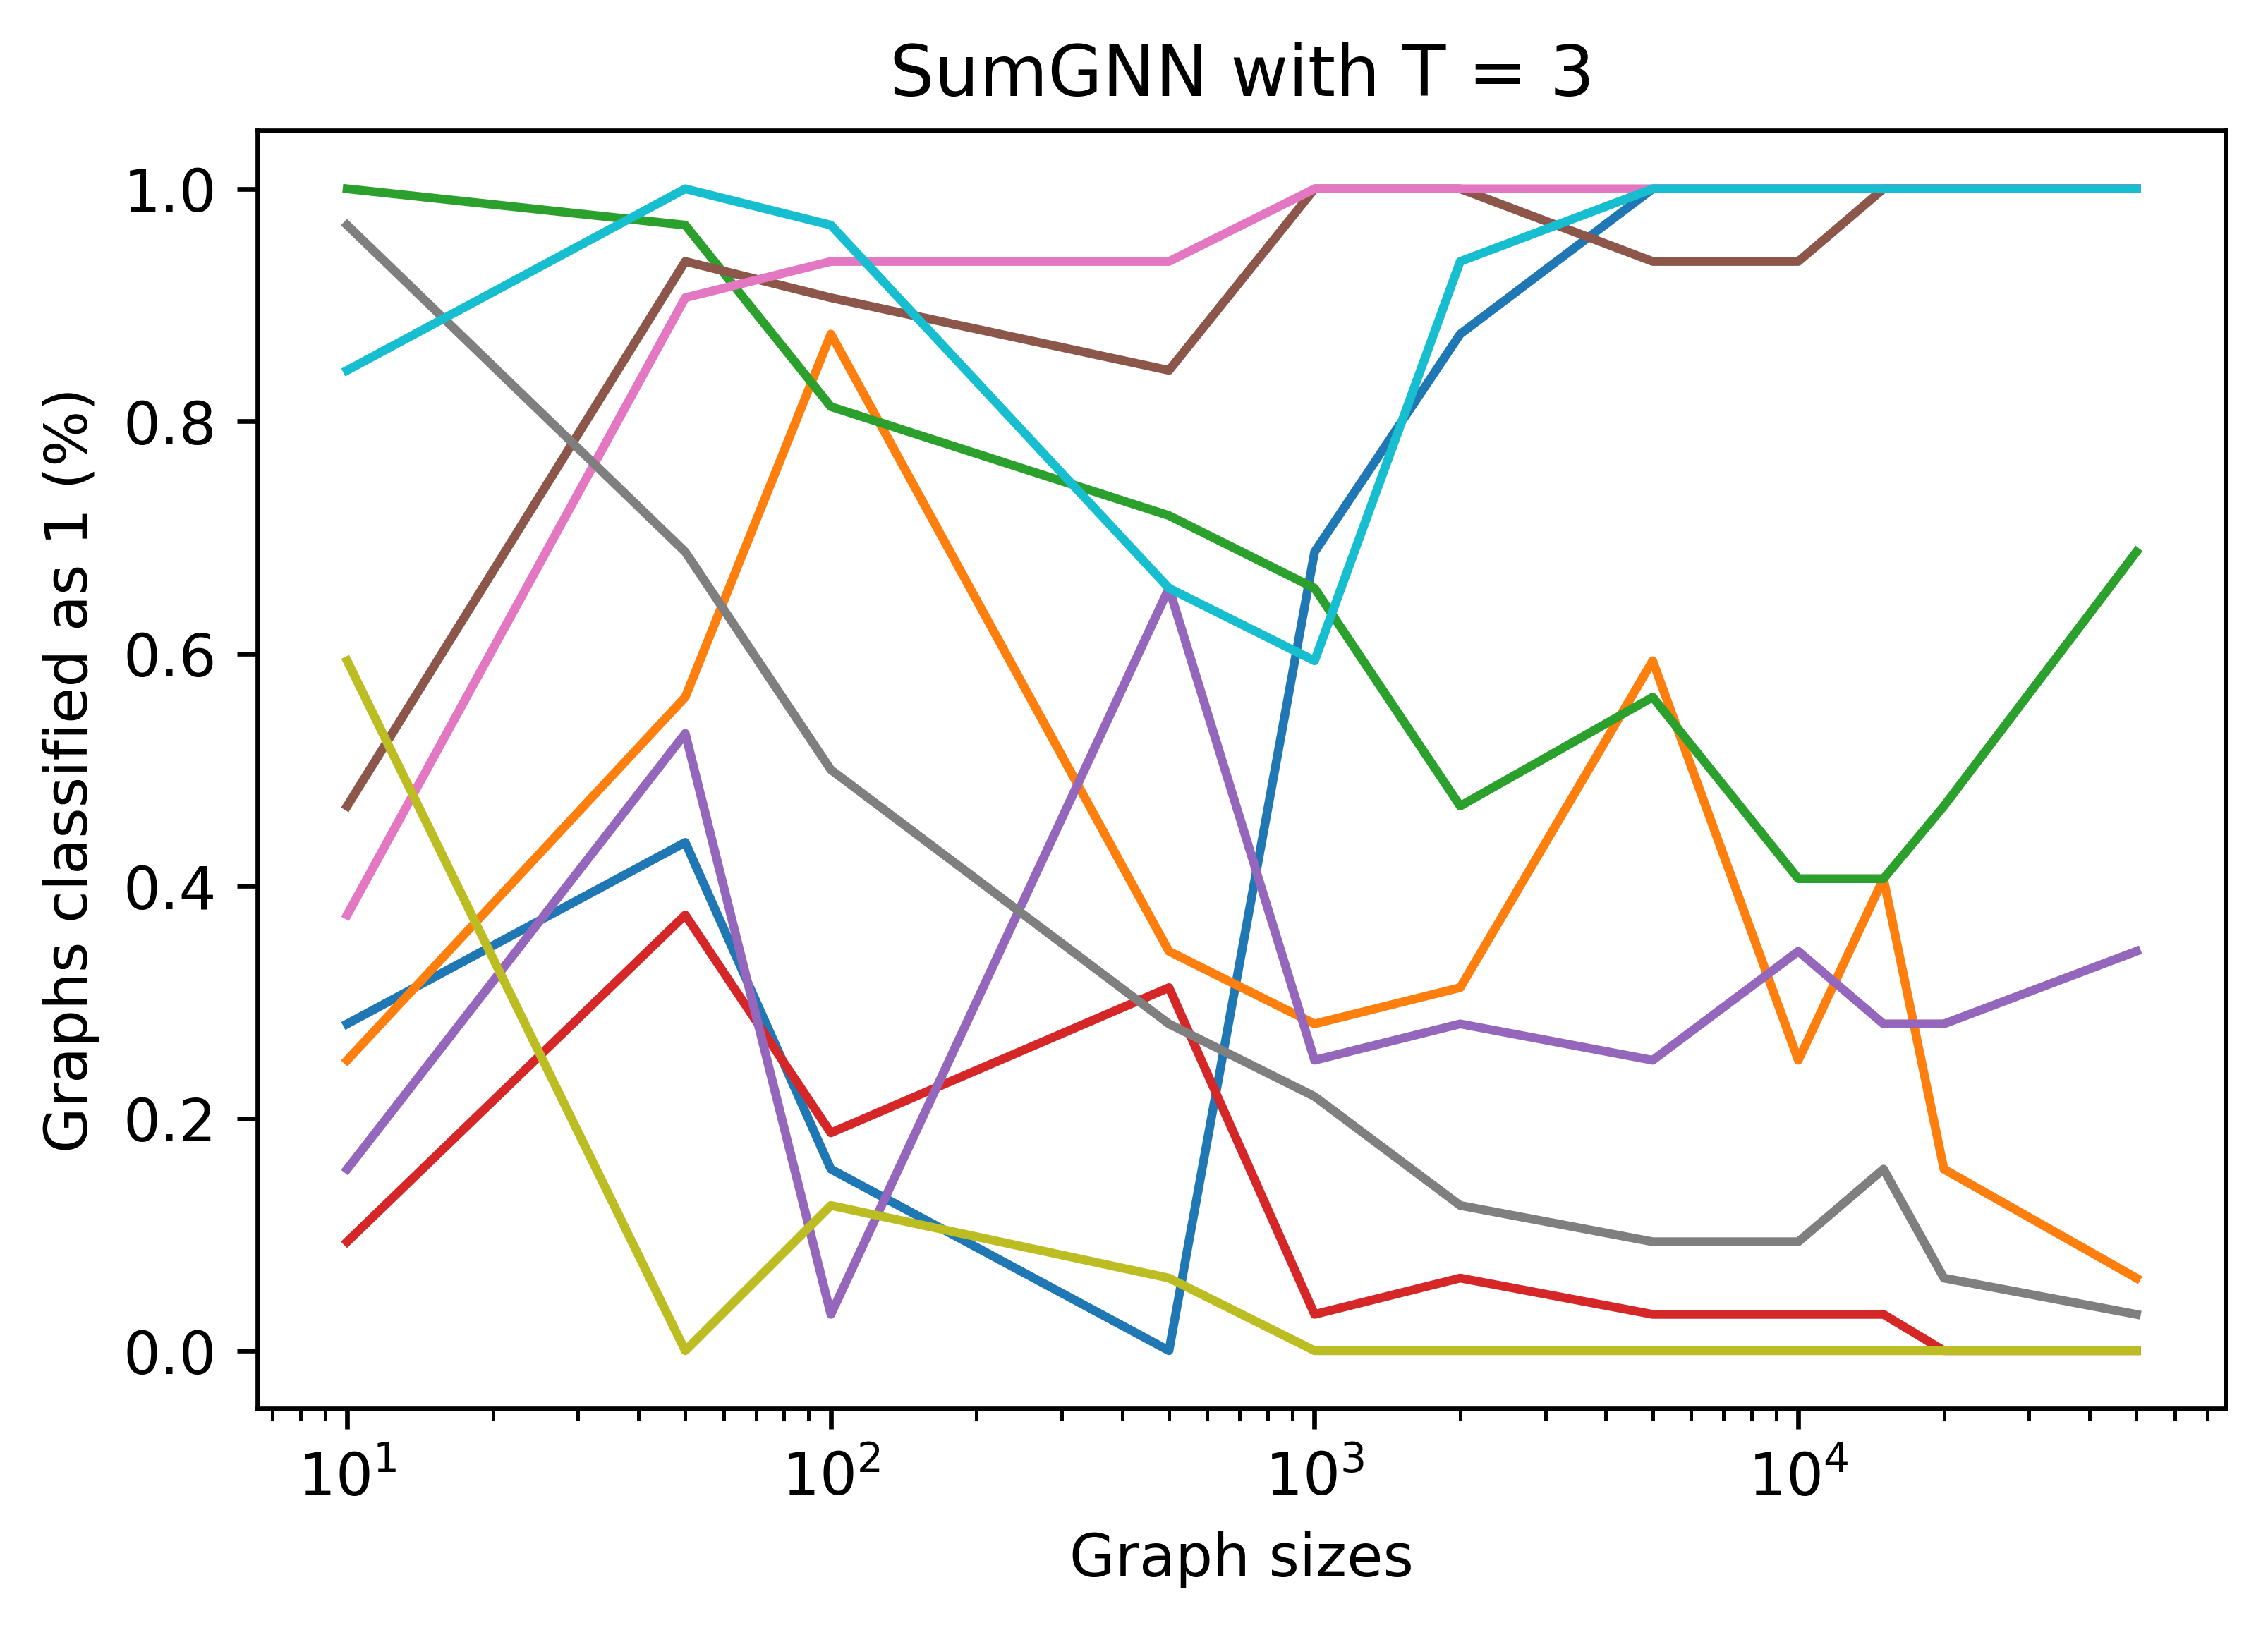

In [28]:
for idx,y in enumerate(csv_numLayer_3):
  y = [item/32 for item in y] + [ext_csv_numLayer_3[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN with T = 3')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/Added_SumGNN with T = 3')
plt.show()

exclude 15k:

In [29]:
x = [10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000, 50000]

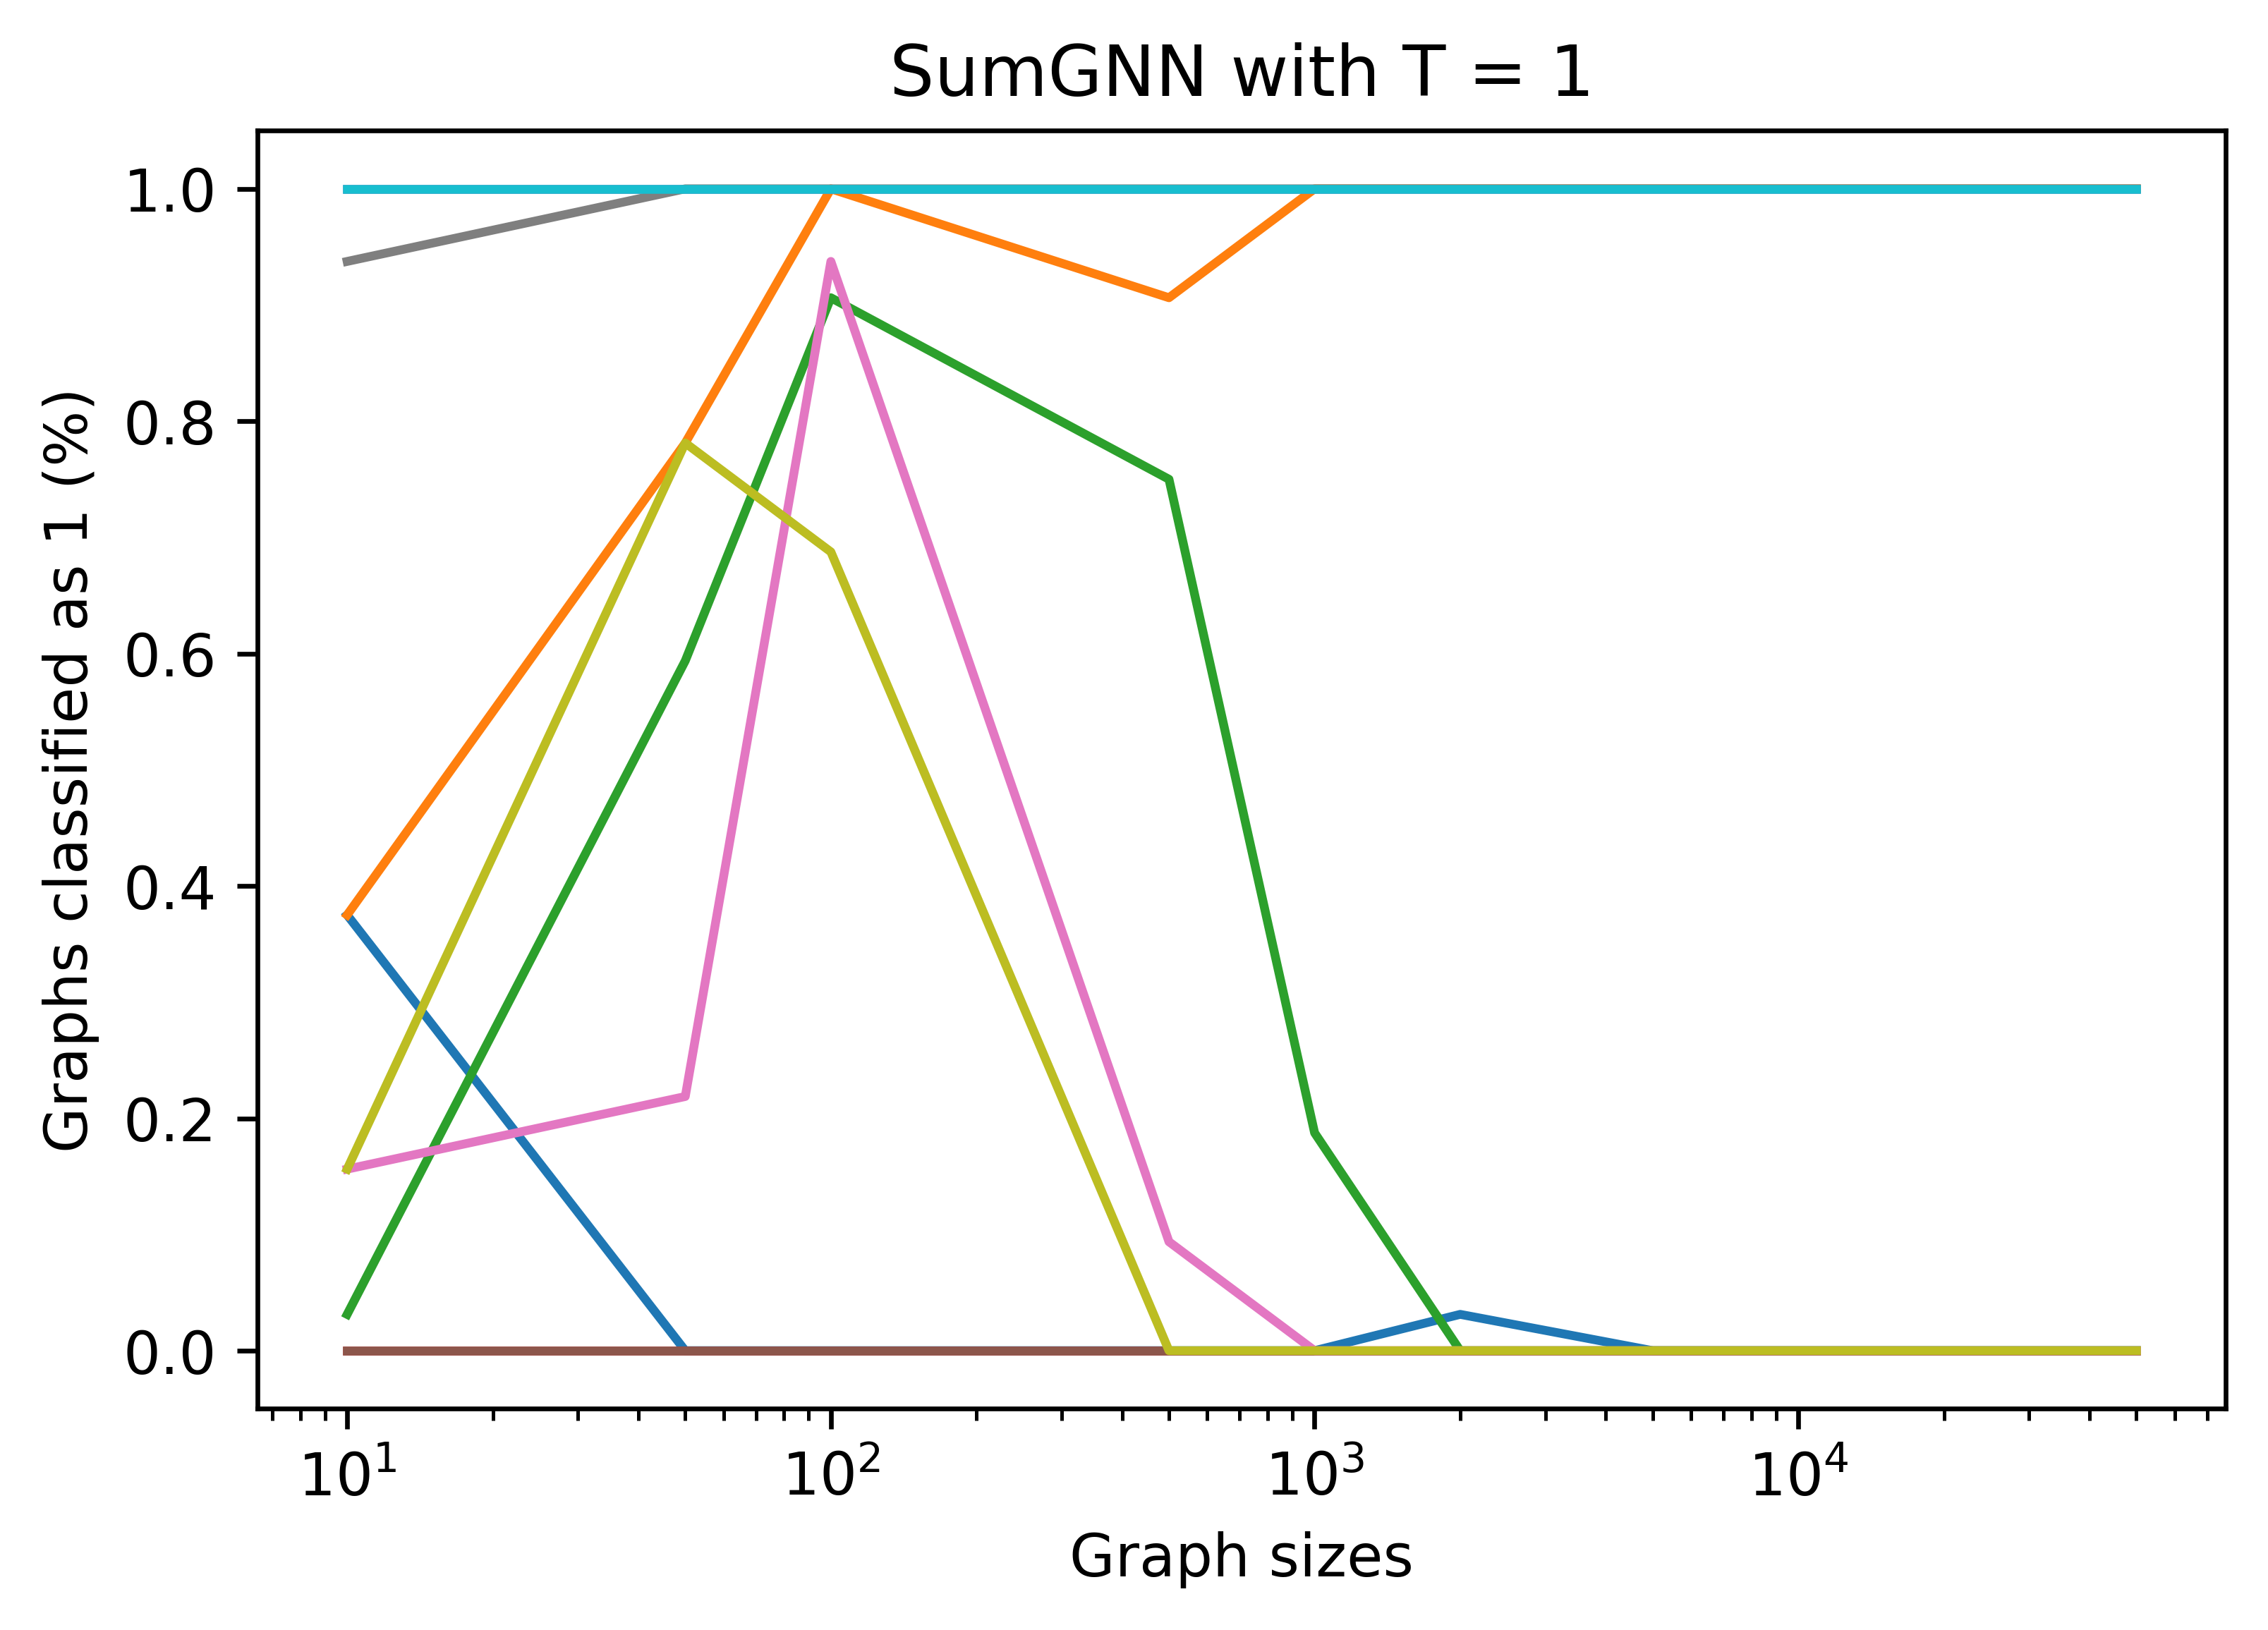

In [30]:
for idx,y in enumerate(csv_numLayer_1):
  y = [item/32 for i,item in enumerate(y) if i != 8] + [ext_csv_numLayer_1[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN with T = 1')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/Added_SumGNN_rm15k with T = 1')
plt.show()

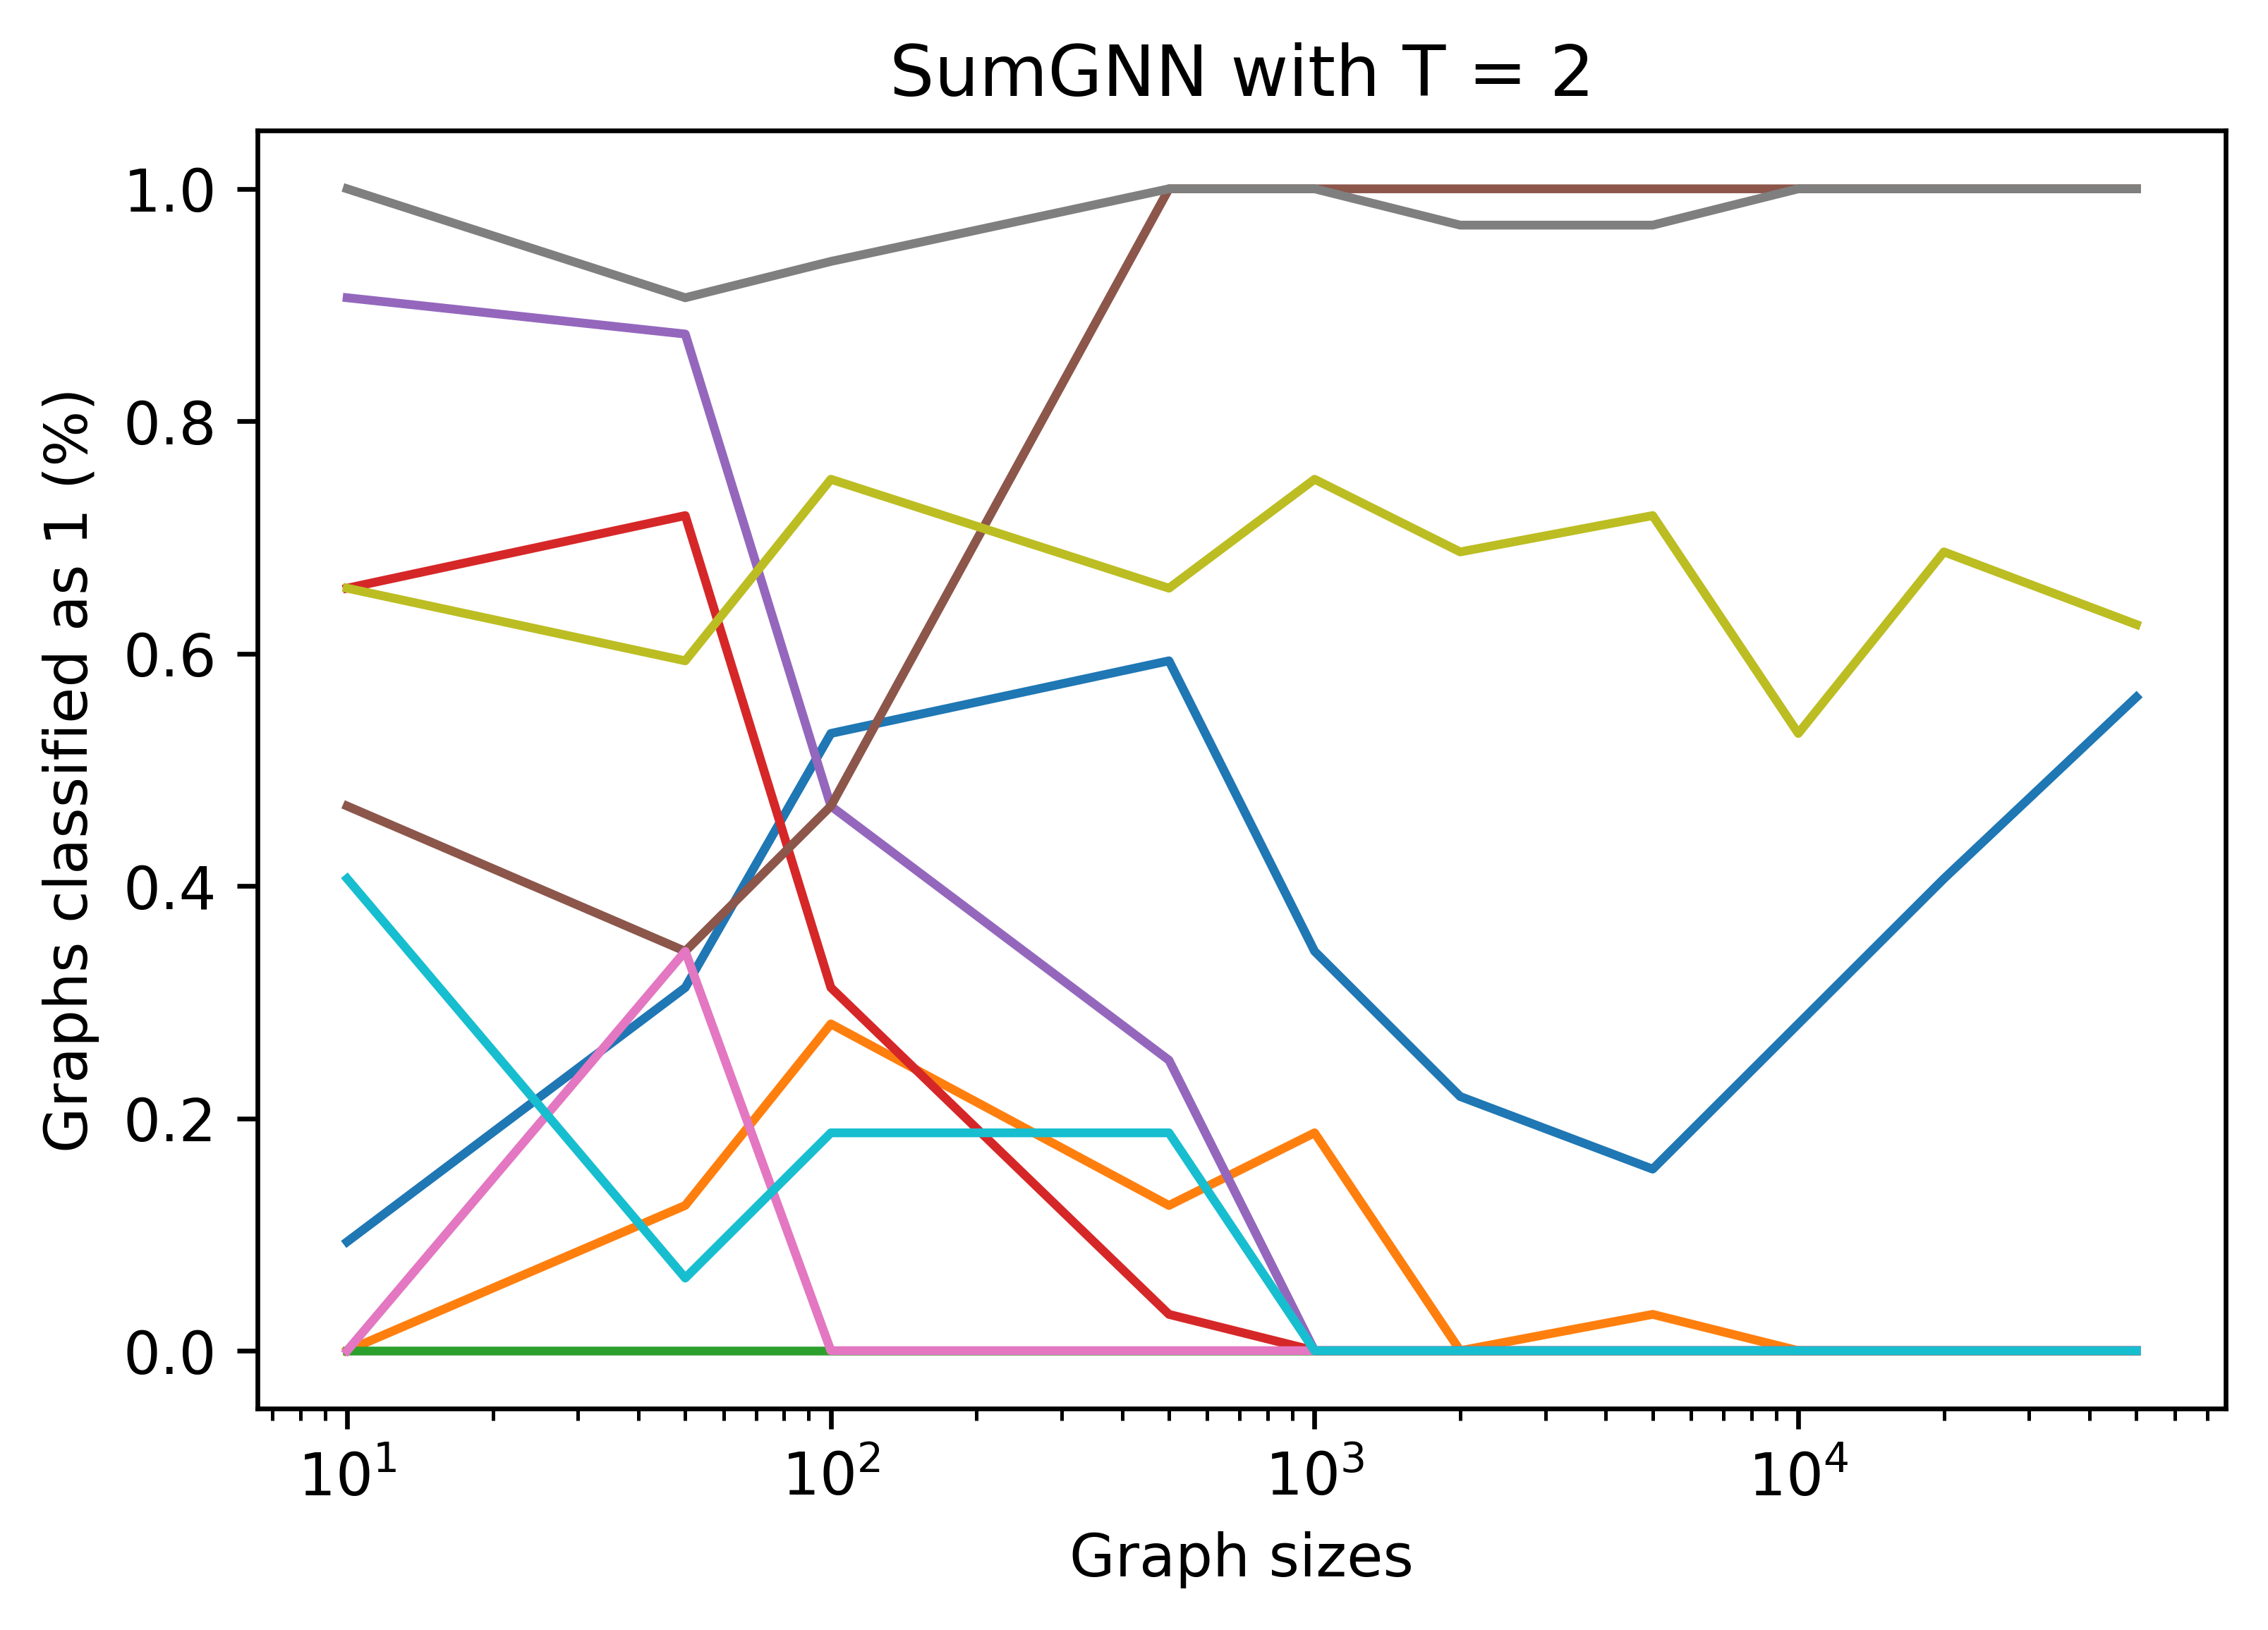

In [31]:
for idx,y in enumerate(csv_numLayer_2):
  y = [item/32 for i,item in enumerate(y) if i != 8] + [ext_csv_numLayer_2[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN with T = 2')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/Added_SumGNN_rm15k with T = 2')
plt.show()

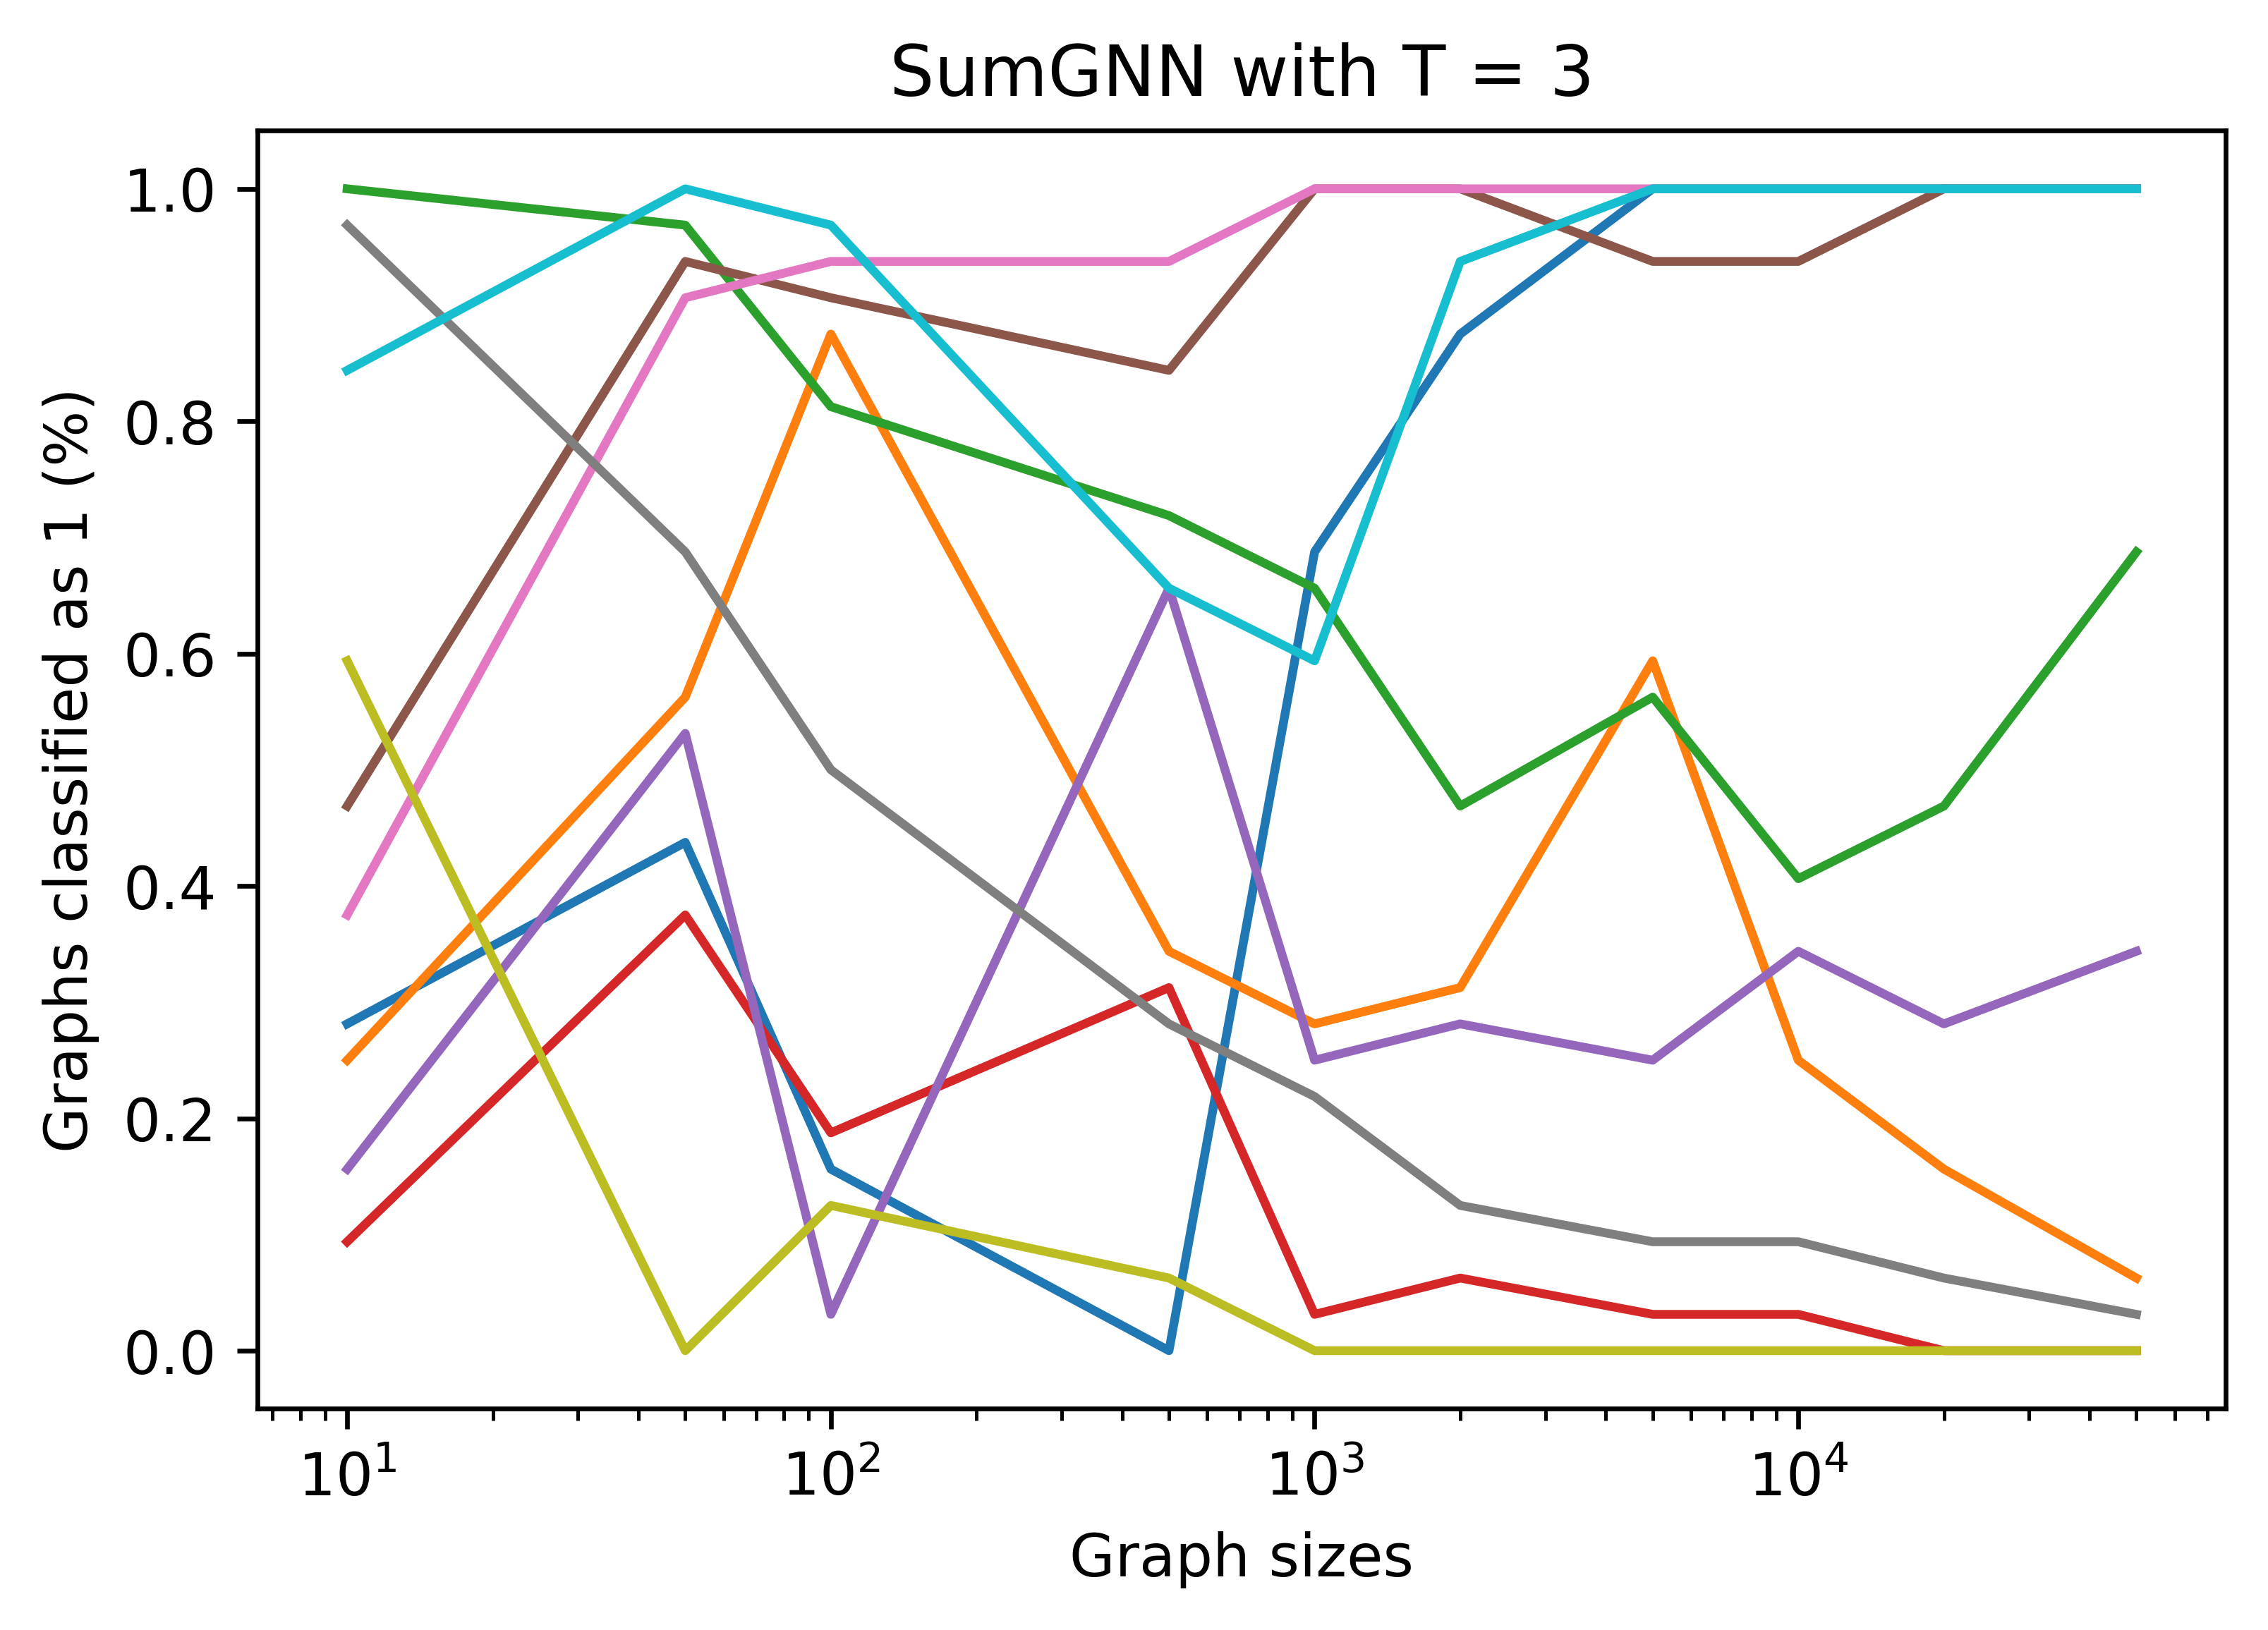

In [32]:
for idx,y in enumerate(csv_numLayer_3):
  y = [item/32 for i,item in enumerate(y) if i != 8] + [ext_csv_numLayer_3[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN with T = 3')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/BaseGNN/Added_SumGNN_rm15k with T = 3')
plt.show()

In [ ]:
import time
time.sleep(100000)